# SPEARHEAD VDA tool

The tool receives a list of time references and outputs the corresponding plots derived from the VDA analysis based on user input.

*The notebook cells are meant to be run serially. In cases where this is not applicable, the user is warned and instructed beforehand via the markdown cells.*

## Imports & Setup

The "Imports & Setup" section imports dependencies used throughout the tool and also indirectly defines constants and default values.

In [1]:
from datetime import datetime, timedelta
from solo_epd_loader import epd_load
from warnings import simplefilter
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
from math import sqrt
import astropy.units as u
from astropy.visualization import quantity_support
from sunpy.coordinates import HeliocentricInertial
import astrospice
from pyonset import Onset, BootstrapWindow, OnsetStatsArray
from ipywidgets import VBox, HBox
import asyncio

from vda_tool_configuration import *

# omit Pandas' PerformanceWarning
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## User Inputs

The "User Inputs" section parameterizes the notebook. The user should run the code cells one at a time and proceed to the next when the input fields are properly filled.

In each cell there is a brief description for the asked inputs.

*Note: In case prior input needs to be changed, all the input cells after the changed one shall be rerun to avoid inconsistencies.*

### Input File

The reference datetimes and the rest of the parameters of this section define the time window for which to download particle data.

- Reference times file: the path to the file which states the reference datetimes. This must be a .csv file with 2 columns. The first column is an `id` for the reference (event), while the second column is the reference datetime itself. The datetime format should be any format that is supported by the `pandas.to_pydatetime` function (i.e. 2024-12-31 00:00:00). The first line of the .csv file should be the headers, although the names of the headers don't matter to the rest of the tool.

- Hours prior to the reference time: an integer indicating hours **before** the reference datetime. The derived datetime is the **start** of the time window for the particle data download.

- Hours after the reference time: an integer indicating hours **after** the reference datetime. The derived datetime is the **end** of the time window for the particle data download.

In [2]:
wgt_ref_times_filepath = widgets.Text(value="",
                                      placeholder="Path to .csv",
                                      description="Reference times file:",
                                      disabled=False,
                                      style=WIDGETS_STYLE,
                                      layout=WIDGETS_LAYOUT)
wgt_tw_prior = widgets.IntSlider(value=2,
                                 min=0,
                                 max=12,
                                 step=1,
                                 description="Hours prior to the reference time:",
                                 disabled=False,
                                 style=WIDGETS_STYLE,
                                 layout=WIDGETS_LAYOUT)
wgt_tw_after = widgets.IntSlider(value=5,
                                 min=0,
                                 max=12,
                                 step=1,
                                 description="Hours after the reference time:",
                                 disabled=False,
                                 style=WIDGETS_STYLE,
                                 layout=WIDGETS_LAYOUT)

VBox([wgt_ref_times_filepath, wgt_tw_prior, wgt_tw_after])

### Particle Data

There is an option to load arleady downloaded data. In case the user has a proper .pkl file (outputted by this notebook) and wants to load the data from it, the "Load data" checkbox should be checked.

In [3]:
wgt_load_data = widgets.Checkbox(value=False,
                                 description="Load data",
                                 disabled=False,
                                 indent=True)
wgt_load_data

Checkbox(value=False, description='Load data')

- In case of "Load data" the user should provide the path to the .pkl file

- In case of a run with new data: the user should state if he wants the data to be saved by checking the "Save data" checkbox and providing a path for the outputted file. The path should state a .pkl file to be created.

In [4]:
if wgt_load_data.value:
    wgt_load_data_filepath = widgets.Text(value="",
                                          placeholder="Path to .pkl",
                                          description="File with saved DataFrame:",
                                          disabled=False,
                                          style=WIDGETS_STYLE,
                                          layout=WIDGETS_LAYOUT)
    vbox = VBox([wgt_load_data_filepath])
else:
    wgt_save_data = widgets.Checkbox(value=False,
                                     description="Save downloaded data",
                                     disabled=False,
                                     indent=True)
    wgt_save_data_filepath = widgets.Text(value="",
                                          placeholder="Path with .pkl extension",
                                          description="File to save data DataFrame:",
                                          disabled=False,
                                          style=WIDGETS_STYLE,
                                          layout=WIDGETS_LAYOUT)
    vbox = VBox([wgt_save_data, wgt_save_data_filepath])
    
vbox

The user should check the sensor, species and viewings of the particle data to be downloaded.
- Resample frequency: the frequency for the data to be resampled. This should be provided as an **offset alias**. [Reference](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for instructions and examples.

**Important Note: In case of data load the checked items and frequency should match the loaded dataset**

In [5]:
list_wgt_chk_sensors = [widgets.Checkbox(value=False,
                                         description=sensor,
                                         disabled=False,
                                         indent=True)
                        for sensor in AVAILABLE_SENSORS]
grp_sensors = VBox(list_wgt_chk_sensors)

list_wgt_chk_particles = [widgets.Checkbox(value=False,
                                           description=particle,
                                           disabled=False,
                                           indent=True)
                          for particle in AVAILABLE_PARTICLES]
grp_particles = VBox(list_wgt_chk_particles)

list_wgt_chk_viewings = [widgets.Checkbox(value=False,
                                          description=viewing,
                                          disabled=False,
                                          indent=True)
                         for viewing in AVAILABLE_VIEWINGS]
grp_viewings = VBox(list_wgt_chk_viewings)

wgt_resample_freq = widgets.Text(value="",
                                 placeholder="Valid offset aliases string (e.g. 5min, 5T, etc)",
                                 description="Resample frequency:",
                                 disabled=False,
                                 style=WIDGETS_STYLE,
                                 layout=WIDGETS_LAYOUT)

VBox([HBox([grp_sensors, grp_particles, grp_viewings]), wgt_resample_freq])

### Energy Channels Grouping

For each series, multiply the values with the respective bin width and sum it all together. Then divide the result with the total bin width (sum of bin widths or max of last energy channel - min of first energy channel).

- `<species>` group size: the number of `<species>` energy channels to be combined into a single energy channel.

In [6]:
dict_wgt_group_size = {}
for particle in [w.description for w in list_wgt_chk_particles if w.value]:
    dict_wgt_group_size[particle] = widgets.IntSlider(value=2,
                                                      min=1,
                                                      max=6,
                                                      step=1,
                                                      description=f"{particle.capitalize()} group size:",
                                                      disabled=False,
                                                      style=WIDGETS_STYLE,
                                                      layout=WIDGETS_LAYOUT)
    
VBox(list(dict_wgt_group_size.values()))

### Onset Determination Method

- Onset determination method: the method to be utilized for the onset determination.

In [7]:
wgt_onset_method = widgets.Dropdown(options=list(AVAILABLE_ONSET_METHODS.keys()),
                                    value=list(AVAILABLE_ONSET_METHODS.keys())[0],
                                    description="Onset determination method:",
                                    disabled=False,
                                    style=WIDGETS_STYLE)
wgt_onset_method

Dropdown(description='Onset determination method:', options=('sigma',), style=DescriptionStyle(description_wid…

The method-specific parameters for the onset determination. For details refer to the relative method.

In [8]:
dict_wgt_onset_params = {}
for parameter, wgt_info in AVAILABLE_ONSET_METHODS[wgt_onset_method.value].items():
    dict_wgt_onset_params[parameter] = wgt_info["widget"](**wgt_info["widget_params"])
VBox(list(dict_wgt_onset_params.values()))

### Onset Selection

- Onset determination method: choose how the onset times that will be used for the VDA plots should be chosen. Options:
  - Use all: every determined onset time will be used
  - Interactive: the execution of the notebook will be halted and the user will be prompted to decide whether to use the determined onset or not individually *(under development)*
  - Custom list: all the determined onsets will be plotted and the execution of the notebook will be halted. The user should construct a list defining which viewing should be used per individual channel. The list items should follow the same order as the one of the displayed plots. *(under development)*

In [9]:
wgt_onset_selection = widgets.Dropdown(options=[("Use all", 0),
                                                ("Interactive", 1),
                                                ("Custom List", 2)],
                                       value=0,
                                       description="Onset determination method:",
                                       disabled=False,
                                       style=WIDGETS_STYLE)
wgt_onset_selection

Dropdown(description='Onset determination method:', options=(('Use all', 0), ('Interactive', 1), ('Custom List…

### Views/Displays

- Display the produced DataFrames: this should be checked to display the intermediate DataFrames

In [10]:
wgt_show_dfs = widgets.Checkbox(value=False,
                                description="Display the produced DataFrames",
                                disabled=False,
                                indent=True,
                                style=WIDGETS_STYLE)

VBox([wgt_show_dfs])

## Run

**The rest of the cells can be run automatically**

*In case the notebook purposefully halts, an error will be raised to the halted cell. The user should continue the run after the halted cell as instructed*

### Reference Times

In [11]:
df_times = pd.read_csv(wgt_ref_times_filepath.value, index_col=0)
df_times.rename(columns={list(df_times.columns)[0]: REF_TIME_COLNAME}, inplace=True)
df_times[REF_TIME_COLNAME] = pd.to_datetime(df_times[REF_TIME_COLNAME])
df_times[START_TIME_COLNAME] = df_times[REF_TIME_COLNAME].apply(lambda x: x - timedelta(hours=wgt_tw_prior.value))
df_times[END_TIME_COLNAME] = df_times[REF_TIME_COLNAME].apply(lambda x: x + timedelta(hours=wgt_tw_after.value))
if wgt_show_dfs.value:
    display(df_times)

### Particle Data

In [12]:
def download_data(show_progress: bool = True) -> pd.DataFrame:
    df_rows = []
    keys = []
    for index, row in df_times.iterrows():
        if show_progress:
            print(f"Working on event {index}...")
        df_row = pd.DataFrame({})
        keys.append(index)
        for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
            for viewing in [w.description for w in list_wgt_chk_viewings if w.value]:
                df_protons, df_electrons, _ = epd_load(sensor=sensor,
                                                       level="l2",
                                                       startdate=row[START_TIME_COLNAME],
                                                       enddate=row[END_TIME_COLNAME],
                                                       viewing=viewing,
                                                       path=DATA_PATH,
                                                       autodownload=True)
                if "protons" in [w.description for w in list_wgt_chk_particles if w.value]:
                    if sensor == "het":
                        flux_cols_name = "H_Flux"
                    elif sensor == "ept":
                        flux_cols_name = "Ion_Flux"
                    df_protons = df_protons[[c for c in df_protons.columns if c[0] == flux_cols_name]]
                    df_protons = df_protons[(df_protons.index >= row[START_TIME_COLNAME]) & (df_protons.index <= row[END_TIME_COLNAME])]
                    df_protons = df_protons.resample(wgt_resample_freq.value, origin="start").mean()
                    df_protons = pd.concat([df_protons], keys=[(sensor, "protons", viewing)], axis="columns")
                    df_protons.index = df_protons.index.floor("min")
                    df_protons = df_protons.rename(lambda x: x.replace(flux_cols_name, PROTON_COLUMN_PREFIX), axis="columns")
                    df_row = pd.concat([df_row, df_protons], axis="columns")
                if "electrons" in [w.description for w in list_wgt_chk_particles if w.value]:
                    if sensor == "het" or sensor == "ept":
                        flux_cols_name = "Electron_Flux"
                    df_electrons = df_electrons[[c for c in df_electrons.columns if c[0] == flux_cols_name]]
                    df_electrons = df_electrons[(df_electrons.index >= row[START_TIME_COLNAME]) & (df_electrons.index <= row[END_TIME_COLNAME])]
                    df_electrons = df_electrons.resample(wgt_resample_freq.value, origin="start").mean()
                    df_electrons = pd.concat([df_electrons], keys=[(sensor, "electrons", viewing)], axis="columns")
                    df_electrons.index = df_electrons.index.floor("min")
                    df_electrons = df_electrons.rename(lambda x: x.replace(flux_cols_name, ELECTRON_COLUMN_PREFIX), axis="columns")
                    df_row = pd.concat([df_row, df_electrons], axis="columns")
        df_rows.append(df_row)
    
    if show_progress:
        print(f"Done")
    return pd.concat(df_rows, keys=keys, names=["Event No", "Time"])

In [13]:
if wgt_load_data.value:
    df_data = pd.read_pickle(wgt_load_data_filepath.value)
else:
    df_data = download_data()
    if wgt_save_data.value:
        df_data.to_pickle(wgt_save_data_filepath.value)

if wgt_show_dfs.value:
    display(df_data)

Working on event 1...
Working on event 2...
Working on event 3...
Working on event 4...
Working on event 5...
Working on event 6...
Working on event 7...
Working on event 8...
Working on event 9...
Working on event 10...
Working on event 11...
Working on event 12...
Working on event 13...
Working on event 14...
Working on event 15...
Working on event 16...
Working on event 17...
Working on event 18...
Working on event 19...
Working on event 20...
Working on event 21...
Working on event 22...
Working on event 23...
Working on event 25...
Working on event 26...
Working on event 27...
Working on event 28...
Working on event 29...
Working on event 30...
Working on event 31...
Working on event 32...
Working on event 33...
Working on event 34...
Working on event 35...
Working on event 36...
Working on event 37...
Working on event 38...
Working on event 39...
Working on event 40...
Working on event 41...
Working on event 42...
Working on event 43...
Working on event 44...
Working on event 45.

### Energies

#### Identify

In [14]:
df_energies = pd.DataFrame({})
df_sensors = []
for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
    df_protons, df_electrons, energies = epd_load(sensor=sensor,
                                                  level="l2",
                                                  startdate=df_times.iloc[0][START_TIME_COLNAME],
                                                  enddate=df_times.iloc[0][END_TIME_COLNAME],
                                                  viewing="sun",
                                                  path=DATA_PATH,
                                                  autodownload=True)
    if sensor == "het":
        flux_cols_name = "H_Flux"
        energy_bins_cols_name = "H_Bins"
    elif sensor == "ept":
        flux_cols_name = "Ion_Flux"
        energy_bins_cols_name = "Ion_Bins"
    df_protons = df_protons.rename(lambda x: x.replace(flux_cols_name, PROTON_COLUMN_PREFIX), axis="columns")
    df_electrons = df_electrons.rename(lambda x: x.replace("Electron_Flux", ELECTRON_COLUMN_PREFIX), axis="columns")

    df_energies_protons = pd.DataFrame({"Low Energy": energies[f"{energy_bins_cols_name}_Low_Energy"], "Bin Width": energies[f"{energy_bins_cols_name}_Width"]},
                                       index=df_protons[PROTON_COLUMN_PREFIX].columns)
    df_energies_protons["High Energy"] = df_energies_protons["Low Energy"] + df_energies_protons["Bin Width"]

    df_energies_electrons = pd.DataFrame({"Low Energy": energies["Electron_Bins_Low_Energy"], "Bin Width": energies["Electron_Bins_Width"]},
                                         index=df_electrons[ELECTRON_COLUMN_PREFIX].columns)
    df_energies_electrons["High Energy"] = df_energies_electrons["Low Energy"] + df_energies_electrons["Bin Width"]

    df_sensors.append(pd.concat([df_energies_protons, df_energies_electrons]))

df_energies = pd.concat(df_sensors, keys=[w.description for w in list_wgt_chk_sensors if w.value], names=["sensor", "channel"])

if wgt_show_dfs.value:
    display(df_energies)

#### Channel Grouping

In [15]:
def group_channels_de(df_to_group: pd.DataFrame, energy_bins_width: list[float], column_prefix: str = "", group_size: int = 2) -> pd.DataFrame:
    # I = ΣI_n*ΔE_n / ΣΔE_n
    channels = list(range(len(df_to_group.columns)))
    grouped_channels = [channels[c:c+group_size] for c in range(0, len(channels), group_size)]
    grouped_all = {}
    for group in grouped_channels:
        de = sum([energy_bins_width[group[i]] for i, _ in enumerate(group)])
        grouped_series = df_to_group.iloc[:, group[0]]*energy_bins_width[group[0]]
        for i, _ in enumerate(group[1:]):
            grouped_series = grouped_series.add(df_to_group.iloc[:, group[i]]*energy_bins_width[group[i]], fill_value=0)
        grouped_all[f"{column_prefix}{'_' if column_prefix != '' else ''}{group[0]}-{column_prefix}{'_' if column_prefix != '' else ''}{group[-1]}"] = grouped_series/de
    df_grouped = pd.DataFrame(grouped_all)
    return df_grouped

In [16]:
df_grouped = pd.DataFrame({})
for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
    for particle in [w.description for w in list_wgt_chk_particles if w.value]:
        if particle == "protons":
            particle_prefix = PROTON_COLUMN_PREFIX
        elif particle == "electrons":
            particle_prefix = ELECTRON_COLUMN_PREFIX
        for viewing in [w.description for w in list_wgt_chk_viewings if w.value]:
            df_temp = group_channels_de(df_data[sensor][particle][viewing][particle_prefix],
                                        list(df_energies.loc[sensor]["Bin Width"]),
                                        column_prefix=particle_prefix,
                                        group_size={
                                            particle: w.value
                                            for particle, w in dict_wgt_group_size.items()
                                        }[particle])
            df_temp = pd.concat([df_temp], keys=[(sensor, particle, viewing, particle_prefix)], axis="columns")
            df_grouped = pd.concat([df_grouped, df_temp], axis="columns")

if wgt_show_dfs.value:
    display(df_grouped)

### Onset

#### Determination

In [17]:
def _onset_detection_sigma(series: pd.Series,
                           s: int = 3,
                           n: int = 3,
                           bg_start: int | datetime = 0,
                           bg_end: int | datetime = 12) -> tuple:
    """Returns:
    
    1. Onset time or None if no event detected
    2. Background start
    3. Background end
    4. Background Level
    5. Threshold
    """
    if type(bg_start) is int:
        bg_start = series.index[bg_start]
    if type(bg_end) is int:
        bg_end = series.index[bg_end]
    bg_level = (bg_series := series[bg_start:bg_end]).mean()
    threshold = bg_level + s*bg_series.std()
    onset_time = None

    streak = 0
    for index, value in series.items():
        if value > threshold:
            streak += 1
            if onset_time is None:
                onset_time = index
        else:
            streak = 0
            onset_time = None

        if streak >= n:
            break
    
    if streak < n:
        onset_time = None

    return(onset_time, bg_start, bg_end, {"bg_level": bg_level, "threshold": threshold})

In [18]:
def _onset_detection_poisson_cusum_bootstrap(series: pd.Series,
                                             sensor: str,
                                             particle: str,
                                             viewing: str,
                                             channel: str,
                                             bg_start: int | datetime = 0,
                                             bg_end: int | datetime = 12,
                                             bootstraps: int = 1000,
                                             cusum_minutes: int = 60,
                                             sample_size: float = 0.75,
                                             limit_averaging: str = "4 min") -> tuple:
    if type(bg_start) is int:
        bg_start = series.index[bg_start]
    if type(bg_end) is int:
        bg_end = series.index[bg_end]
    df = pd.DataFrame(series)
    df.index.freq = wgt_resample_freq.value
    protons = Onset(spacecraft="Solar Orbiter",
                    sensor=sensor.upper(),
                    species=particle[:-1], # rest of the tool uses the plurar form. This function needs singular, so omit the final "s"
                    viewing=viewing,
                    data_level="l2",
                    data_path="",
                    start_date="",
                    end_date="",
                    data=df)
    channels = channel.split("-")
    protons.set_custom_channel_energies(low_bounds=[df_energies.loc[sensor, channels[0]]["Low Energy"]],
                                        high_bounds=[df_energies.loc[sensor, channels[1]]["High Energy"]],
                                        unit="MeV")
    bg = BootstrapWindow(start=bg_start.strftime("%Y-%m-%d %H:%M"), end=bg_end.strftime("%Y-%m-%d %H:%M"), bootstraps=bootstraps)
    rng = 101010101
    protons.onset_statistics_per_channel(channels=channel,
                                         background=bg,
                                         cusum_minutes=cusum_minutes,
                                         sample_size=sample_size,
                                         viewing=protons.viewing,
                                         limit_averaging=limit_averaging,
                                         random_seed=rng,
                                         print_output=False)
    
    return (protons.onset_statistics[channel][0], bg_start, bg_end, protons.onset_statistics[channel])

In [19]:
def onset_detection(series: pd.Series, method: str = "sigma", **kwargs) -> tuple:
    if method == "sigma":
        onset_results = _onset_detection_sigma(series,
                                               kwargs["s"],
                                               kwargs["n"],
                                               kwargs["bg_start"],
                                               kwargs["bg_end"])
    elif method == "poisson_cusum_bootstrap":
        onset_results = _onset_detection_poisson_cusum_bootstrap(series,
                                                                 kwargs["sensor"],
                                                                 kwargs["particle"],
                                                                 kwargs["viewing"],
                                                                 kwargs["channel"],
                                                                 kwargs["bg_start"],
                                                                 kwargs["bg_end"],
                                                                 kwargs["bootstraps"],
                                                                 kwargs["cusum_minutes"],
                                                                 kwargs["sample_size"],
                                                                 kwargs["limit_averaging"])
    else:
        raise ValueError(f"Method named \"{method}\" is not implented")
    return onset_results

In [20]:
def onset_detection_df(df: pd.DataFrame, method: str = "sigma", **kwargs) -> dict:
    df_onsets = pd.DataFrame({})
    for index_event, df_event in df.groupby(level=0):
        for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
            for particle in [w.description for w in list_wgt_chk_particles if w.value]:
                if particle == "protons":
                    particle_prefix = PROTON_COLUMN_PREFIX
                elif particle == "electrons":
                    particle_prefix = ELECTRON_COLUMN_PREFIX
                for viewing in [w.description for w in list_wgt_chk_viewings if w.value]:
                    for column_name in (df_inner := df_event[sensor][particle][viewing][particle_prefix]).columns:
                        kwargs["sensor"] = sensor
                        kwargs["particle"] = particle
                        kwargs["viewing"] = viewing
                        kwargs["channel"] = column_name
                        try:
                            onset_time, bg_start, bg_stop, method_specific = onset_detection(df_inner[column_name].droplevel(0, axis="index"),
                                                                                                method,
                                                                                                **kwargs)
                            df_onsets = pd.concat([df_onsets, pd.DataFrame({"Onset Time": [onset_time],
                                                                            "Background Start": [bg_start],
                                                                            "Background End": [bg_stop],
                                                                            "Method Specific": [method_specific]
                                                                            },
                                                                            index=[[index_event], [sensor], [particle], [viewing], [particle_prefix], [column_name]])])
                        except Exception as e:
                            print(index_event, type(e).__name__, kwargs)
                            df_onsets = pd.concat([df_onsets, pd.DataFrame({"Onset Time": [pd.NaT],
                                                                            "Background Start": [pd.NaT],
                                                                            "Background End": [pd.NaT],
                                                                            "Method Specific": [None]
                                                                            },
                                                                            index=[[index_event], [sensor], [particle], [viewing], [particle_prefix], [column_name]])])
    df_onsets.index.names = ["Event No", "sensor", "particle", "viewing", "prefix", "channels"]
    return df_onsets

In [21]:
df_onsets = onset_detection_df(df_grouped, wgt_onset_method.value, **{parameter: w.value
                                                                      for parameter, w in dict_wgt_onset_params.items()})

if wgt_show_dfs.value:
    display(df_onsets)

In [22]:
df_onsets_existing = df_onsets[~pd.isna(df_onsets["Onset Time"])]

if wgt_show_dfs.value:
    display(df_onsets_existing)

#### Selection

In [23]:
df_options = df_onsets_existing.reorder_levels(["Event No", "sensor", "particle", "prefix", "channels", "viewing"])

if wgt_show_dfs.value:
    display(df_options)

In [24]:
def plot_onset(series: pd.Series,
               onset_time: datetime,
               bg_start_time: datetime,
               bg_end_time: datetime,
               title: str) -> None:
    ax = series.fillna(0).plot(title=title,
                               logy=True,
                               label="Data")
    ax.set_ylim((ylim := ax.get_ylim())[0]*0.01, ylim[1]*100)
    ax.axvline(onset_time, linestyle='--', label="Onset time")
    ylim_top = ax.get_ylim()[1]
    ax.fill_between([bg_start_time, bg_end_time], 0, ylim_top, color="green", alpha=0.25, label="BG sample")
    ax.set_ylim(top=ylim_top)
    ax.legend()
    plt.axes(ax)
    plt.tight_layout()
    plt.show()

In [25]:
if wgt_onset_selection.value == 0:
    # Use all
    chosen_onsets = None
elif wgt_onset_selection.value == 1:
    # Interactive
    # from ipywidgets import Button
    # widget_btns = [Button(description=viewing) for viewing in [w.description for w in list_wgt_chk_viewings if w.value]]
    # widget_btns.append(Button(description="none"))

    # plt.ion()
    # # fig, ax = plt.subplots(figsize=(10, 8))
    # fig, ax = plt.subplots()
    # # line1, = ax.plot([pd.Timestamp('2020-07-21 05:15:00'), pd.Timestamp('2020-07-21 05:20:00')], [1, 10])
    # line1, = ax.plot([], [])

    # def wait_for_change(*widget_btns):
    #     future = asyncio.Future()
    #     def getvalue(change):
    #         future.set_result(change.description)
    #         for btn in widget_btns:
    #             btn.on_click(getvalue, remove=True)
    #         # we need to free up the binding to getvalue to avoid an IvalidState error
    #         # buttons don't support unobserve
    #         # so use `remove=True` 
    #     for btn in widget_btns:
    #         btn.on_click(getvalue)
    #     return future

    # async def select():
    #     df_selections = pd.DataFrame({})
    #     for index_event, df_event in df_options.groupby(level=0):
    #         for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
    #             for particle in [w.description for w in list_wgt_chk_particles if w.value]:
    #                 if particle == "protons":
    #                     particle_prefix = PROTON_COLUMN_PREFIX
    #                 elif particle == "electrons":
    #                     particle_prefix = ELECTRON_COLUMN_PREFIX
    #                 for channel, df_channel in df_event.loc[index_event, sensor, particle, particle_prefix].groupby(level=0):
    #                     channel_low = (channels := channel.split("-"))[0]
    #                     channel_high = channels[1]
    #                     # viewings = []
    #                     # widget_btns = []
    #                     for viewing, df_viewing in df_channel.groupby(level=1):
    #                         plot_onset(df_grouped.loc[index_event][sensor, particle, viewing, particle_prefix, channel],
    #                                 df_channel.loc[channel, viewing]["Onset Time"].to_pydatetime(),
    #                                 df_channel.loc[channel, viewing]["Background Start"].to_pydatetime(),
    #                                 df_channel.loc[channel, viewing]["Background End"].to_pydatetime(),
    #                                 f"Event {index_event}, {sensor}/{particle}, {df_energies.loc[sensor, channel_low]['Low Energy']:.2f}-{df_energies.loc[sensor, channel_high]['High Energy']:.2f} MeV, {viewing}")
    #                     #     series = df_grouped.loc[index_event][sensor, particle, viewing, particle_prefix, channel]
    #                     #     onset_time = df_channel.loc[channel, viewing]["Onset Time"].to_pydatetime()
    #                     #     bg_start_time = df_channel.loc[channel, viewing]["Background Start"].to_pydatetime()
    #                     #     bg_end_time = df_channel.loc[channel, viewing]["Background End"].to_pydatetime()
    #                     #     title = f"Event {index_event}, {sensor}/{particle}, {df_energies.loc[sensor, channel_low]['Low Energy']:.2f}-{df_energies.loc[sensor, channel_high]['High Energy']:.2f} MeV, {viewing}"
    #                     #     # plt.ion()
    #                     #     # fig, ax = plt.subplots(figsize=(10, 8))
    #                     #     # ax.plot(series.fillna(0))
    #                     #     # ax = series.fillna(0).plot(title=title,
    #                     #     #        logy=True,
    #                     #     #     #    ylim=(1e-4, 1e4),
    #                     #     #        label="Data")
    #                     #     series = series.fillna(0)
    #                     #     line1.set_xdata(list(series.index))
    #                     #     line1.set_ydata(list(series))
    #                     #     # ax.set_title(title)
    #                     #     # ax.set_ylim((ylim := ax.get_ylim())[0]*0.01, ylim[1]*100)
    #                     #     # ax.axvline(onset_time, linestyle='--', label="Onset time")
    #                     #     # ylim_top = ax.get_ylim()[1]
    #                     #     # ax.fill_between([bg_start_time, bg_end_time], 0, ylim_top, color="green", alpha=0.25, label="BG sample")
    #                     #     # ax.set_ylim(top=ylim_top)
    #                     #     # ax.legend()
    #                     #     fig.canvas.draw()
    #                     #     fig.canvas.flush_events()
    #                     #     # plt.axes(ax)
    #                     #     # plt.tight_layout()
    #                     #     # plt.show()
    #                     #     # viewings.append(viewing)
    #                     #     # widget_btns.append(Button(description=viewing))
    #                     # # viewings.append("none")
    #                     # # selection = None
    #                     # # widget_btns.append(Button(description="none"))
    #                     # selection = await wait_for_change(*widget_btns)
    #                     # print(selection)
    #         #             break
    #         #         break
    #         #     break
    #         # break

    # asyncio.create_task(select())
    # HBox(widget_btns)
    pass
elif wgt_onset_selection.value == 2:
    # Custom list
    df_selections = pd.DataFrame({})
    for index_event, df_event in df_options.groupby(level=0):
        for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
            for particle in [w.description for w in list_wgt_chk_particles if w.value]:
                if particle == "protons":
                    particle_prefix = PROTON_COLUMN_PREFIX
                elif particle == "electrons":
                    particle_prefix = ELECTRON_COLUMN_PREFIX
                for channel, df_channel in df_event.loc[index_event, sensor, particle, particle_prefix].groupby(level=0):
                    channel_low = (channels := channel.split("-"))[0]
                    channel_high = channels[1]
                    for viewing, df_viewing in df_channel.groupby(level=1):
                        plot_onset(df_grouped.loc[index_event][sensor, particle, viewing, particle_prefix, channel],
                                df_channel.loc[channel, viewing]["Onset Time"].to_pydatetime(),
                                df_channel.loc[channel, viewing]["Background Start"].to_pydatetime(),
                                df_channel.loc[channel, viewing]["Background End"].to_pydatetime(),
                                f"Event {index_event}, {sensor}/{particle}, {df_energies.loc[sensor, channel_low]['Low Energy']:.2f}-{df_energies.loc[sensor, channel_high]['High Energy']:.2f} MeV, {viewing}")
    
    assert False

In [26]:
if wgt_onset_selection.value == 2:
    # chosen_onsets = ["sun", "north", None]
    chosen_onsets = []

### VDA

#### Channels

In [27]:
df_channels_chars = pd.DataFrame({})
for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
    for particle in [w.description for w in list_wgt_chk_particles if w.value]:
        if particle == "protons":
            particle_prefix = PROTON_COLUMN_PREFIX
        elif particle == "electrons":
            particle_prefix = ELECTRON_COLUMN_PREFIX
        for channel in list(df_grouped[sensor][particle][[w.description for w in list_wgt_chk_viewings if w.value][0]][particle_prefix].columns):
            channels = channel.split("-")
            low_energy = df_energies.loc[sensor, channels[0]]["Low Energy"]
            high_energy = df_energies.loc[sensor, channels[1]]["High Energy"]
            geo_mean = sqrt(low_energy) * sqrt(high_energy)
            inv_beta = 1/sqrt(1-(1/(1 + geo_mean/M_REST[particle]))**2)
            df_channels_chars = pd.concat([df_channels_chars, pd.DataFrame({"Geomagnetic Mean": [geo_mean],
                                                                            "Inverse Beta": [inv_beta]},
                                                                            index=[[sensor], [particle], [channel]])])
df_channels_chars.index.names = ["sensor", "particle", "channel"]

if wgt_show_dfs.value:
    display(df_channels_chars)

#### Spacecraft

In [28]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f4360d1f9a0>

In [29]:
kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
solo_kernel = kernels[0]
coverage = solo_kernel.coverage('SOLAR ORBITER')
print(coverage.iso)

/home/liadlow/Development/Work/NOA/Projects/SPEARHEAD/tools/VDA/venv_vda_tool/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['2020-02-10 04:55:49.670' '2030-11-20 05:12:55.385']


/home/liadlow/Development/Work/NOA/Projects/SPEARHEAD/tools/VDA/venv_vda_tool/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/liadlow/Development/Work/NOA/Projects/SPEARHEAD/tools/VDA/venv_vda_tool/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [30]:
heliocentric = HeliocentricInertial()

#### Plots

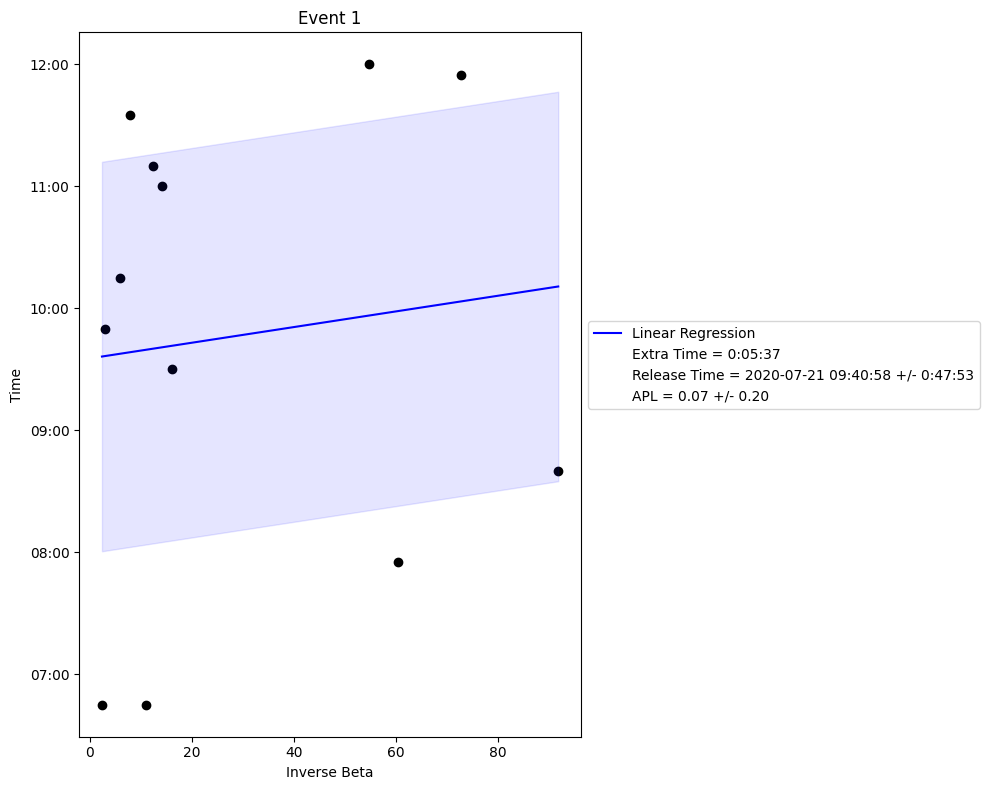

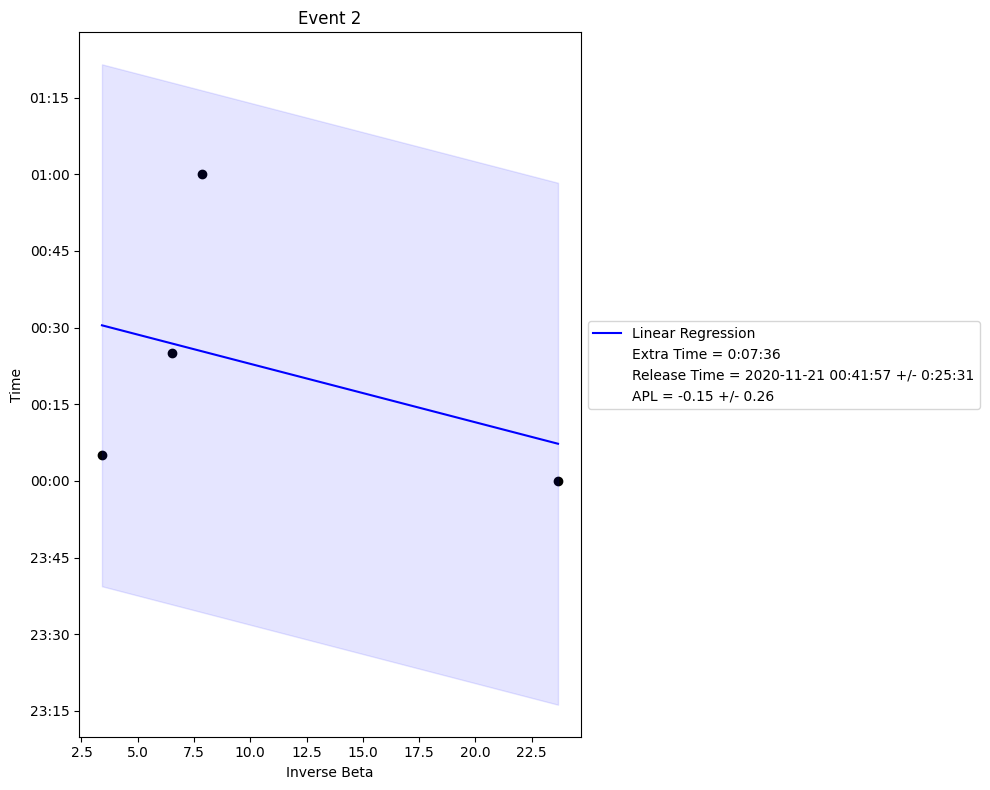

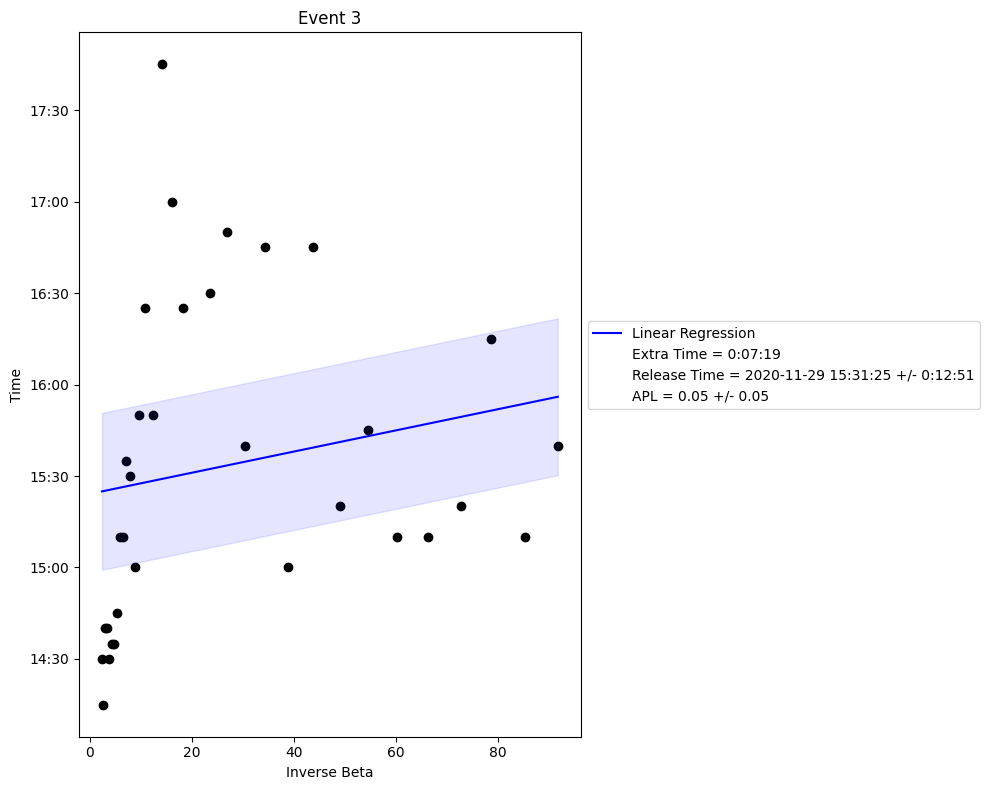

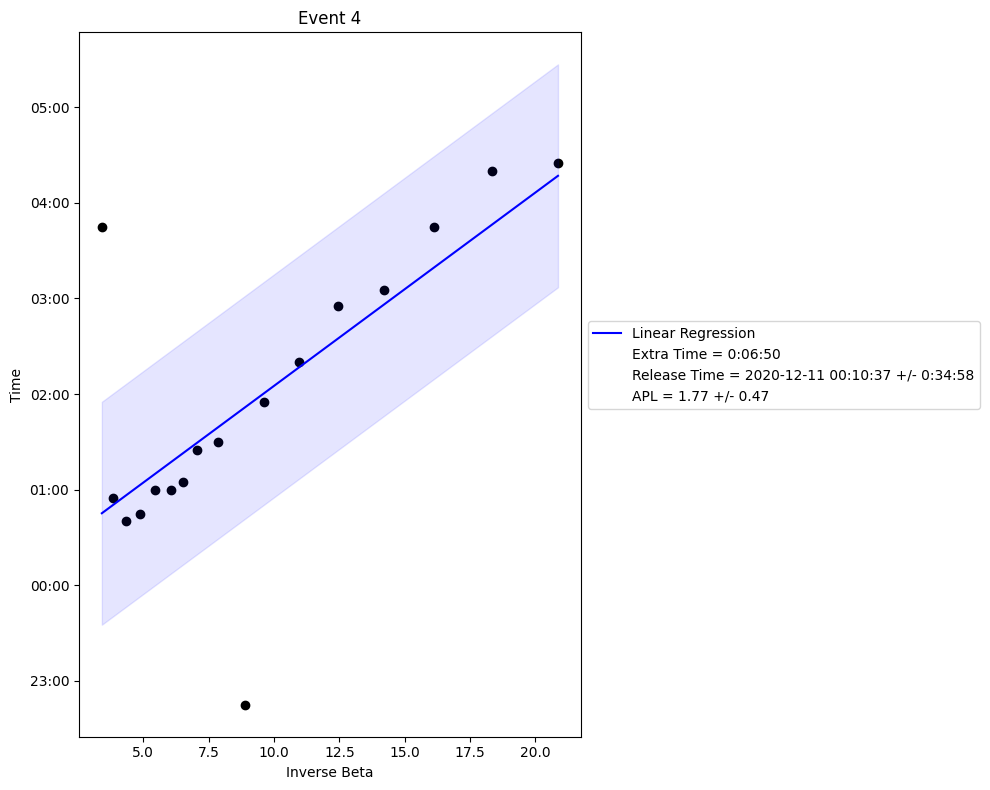

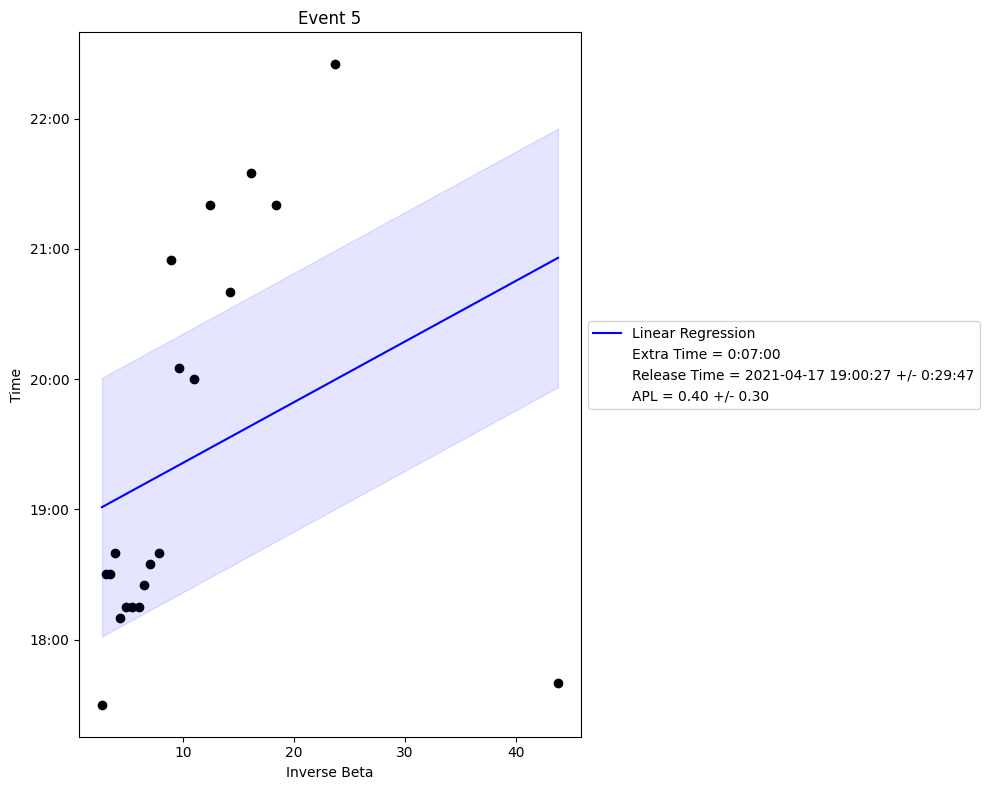

Not enough onset points in event 6.


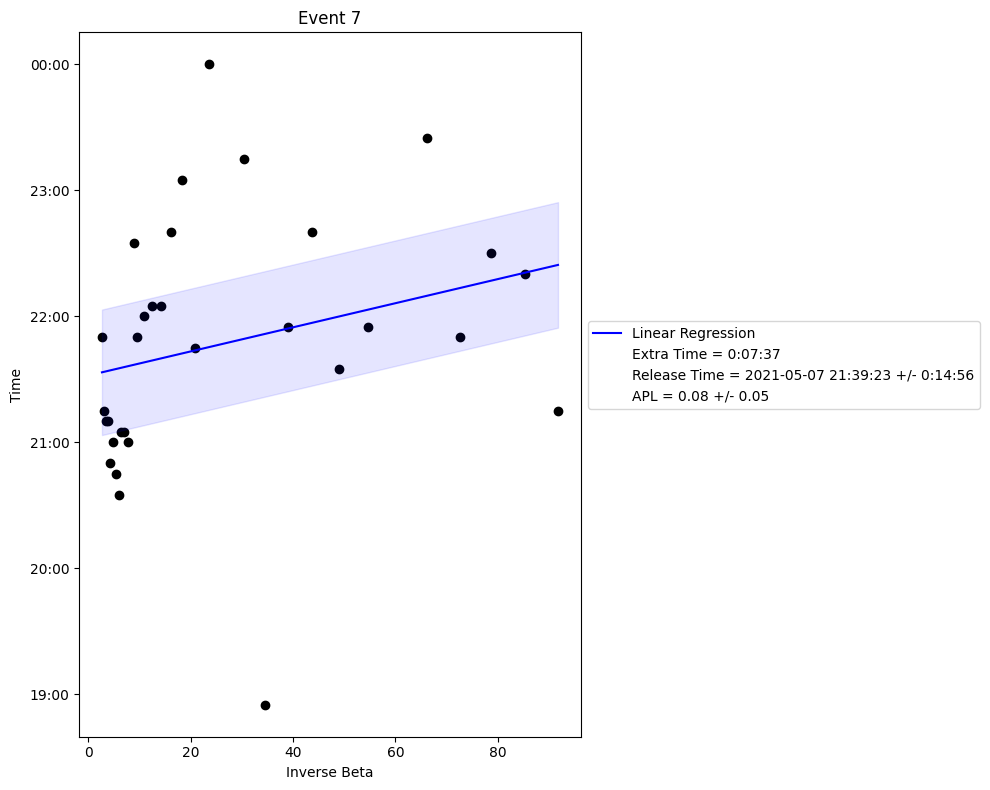

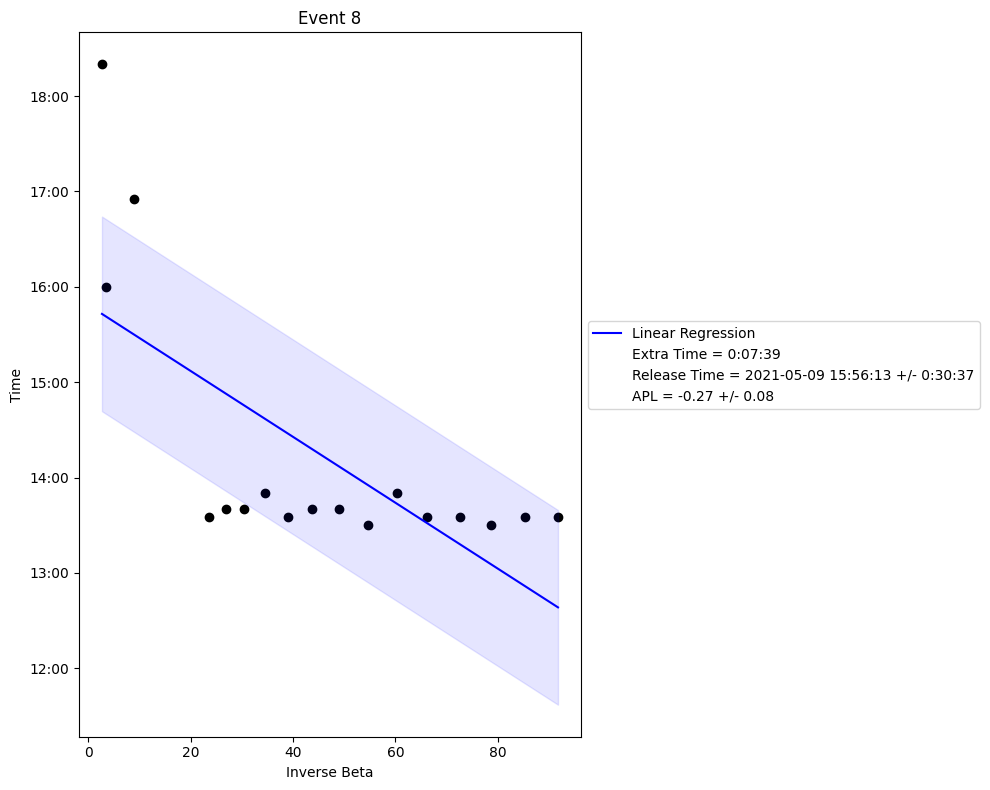

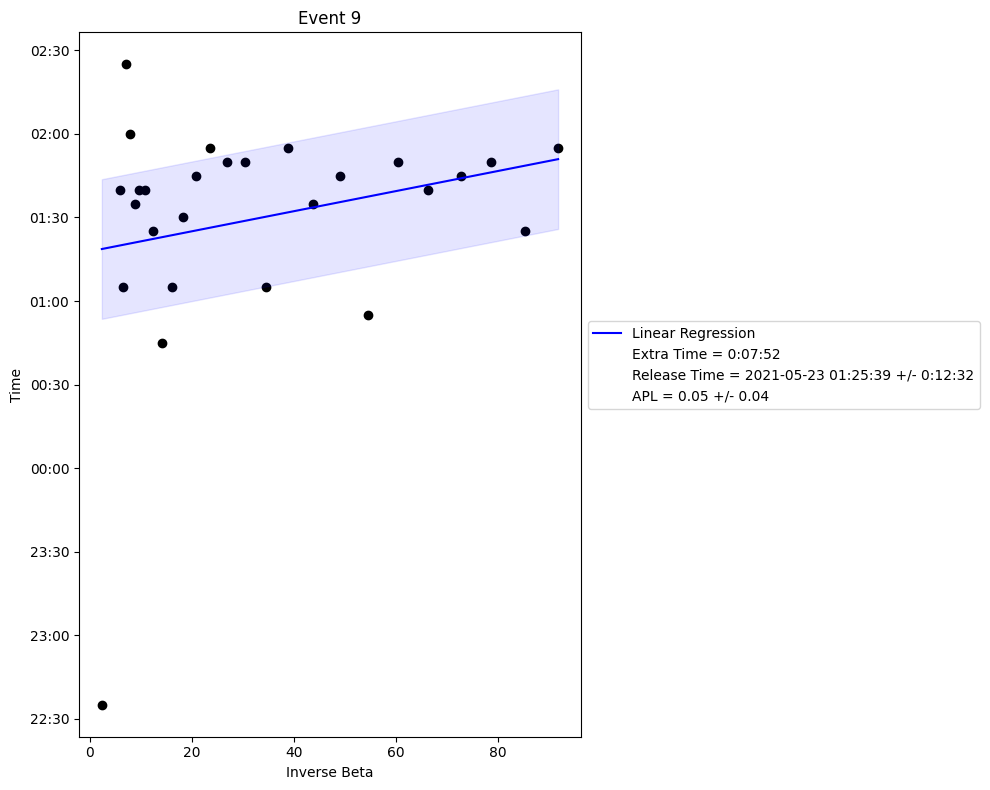

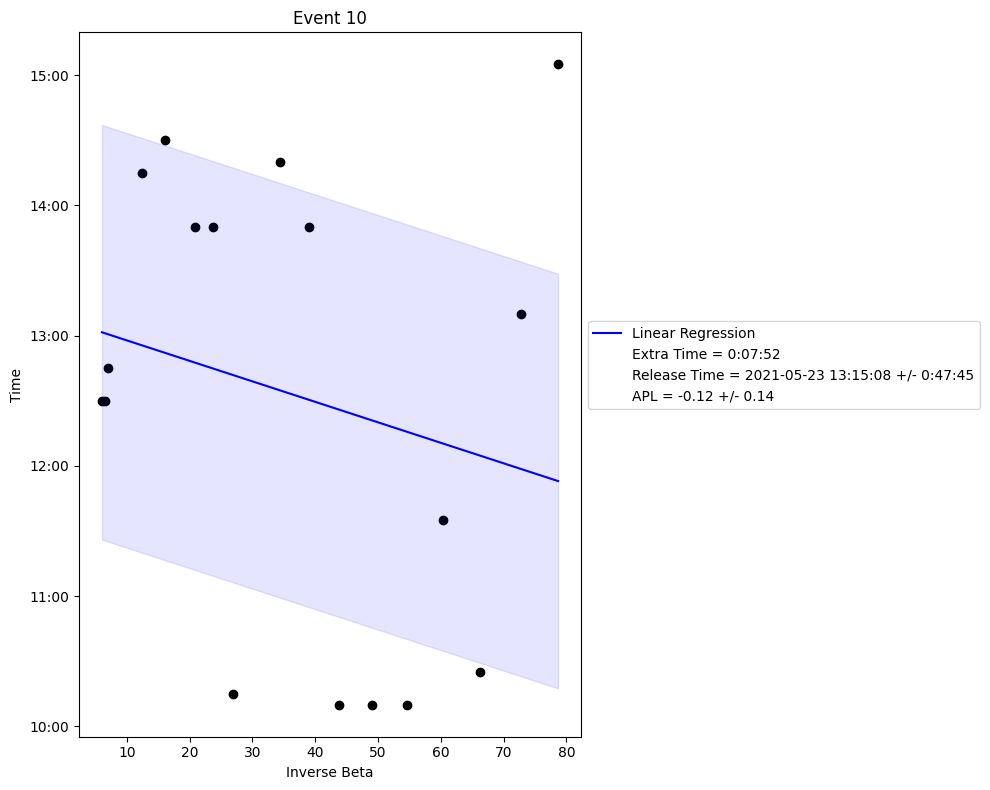

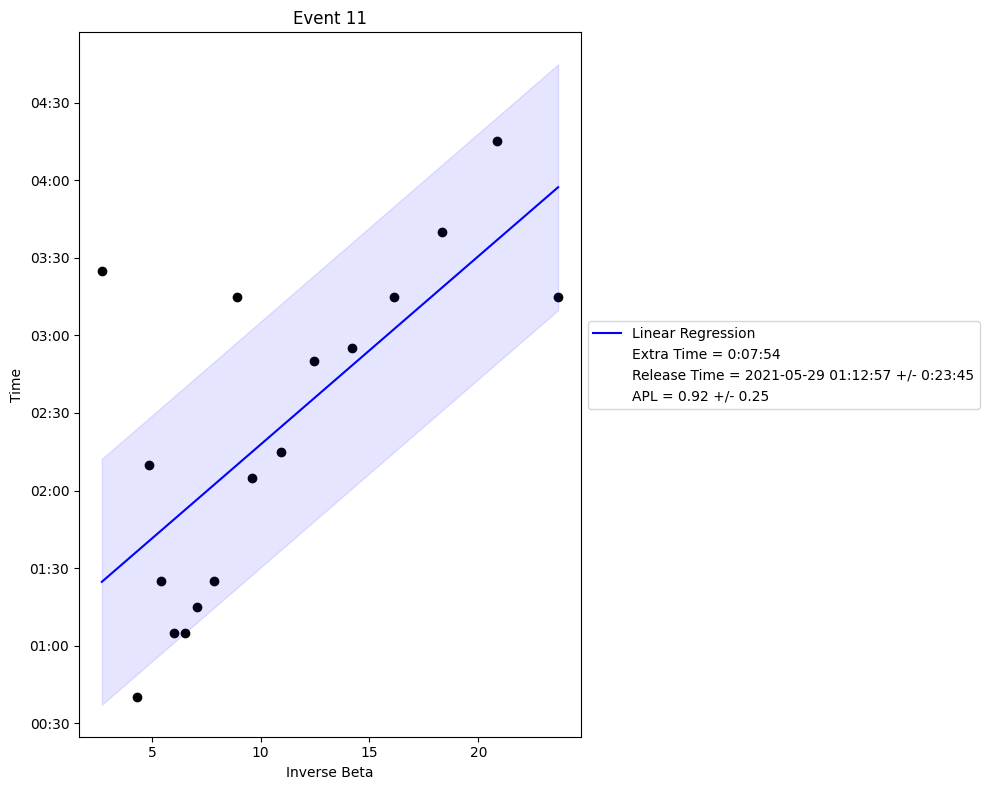

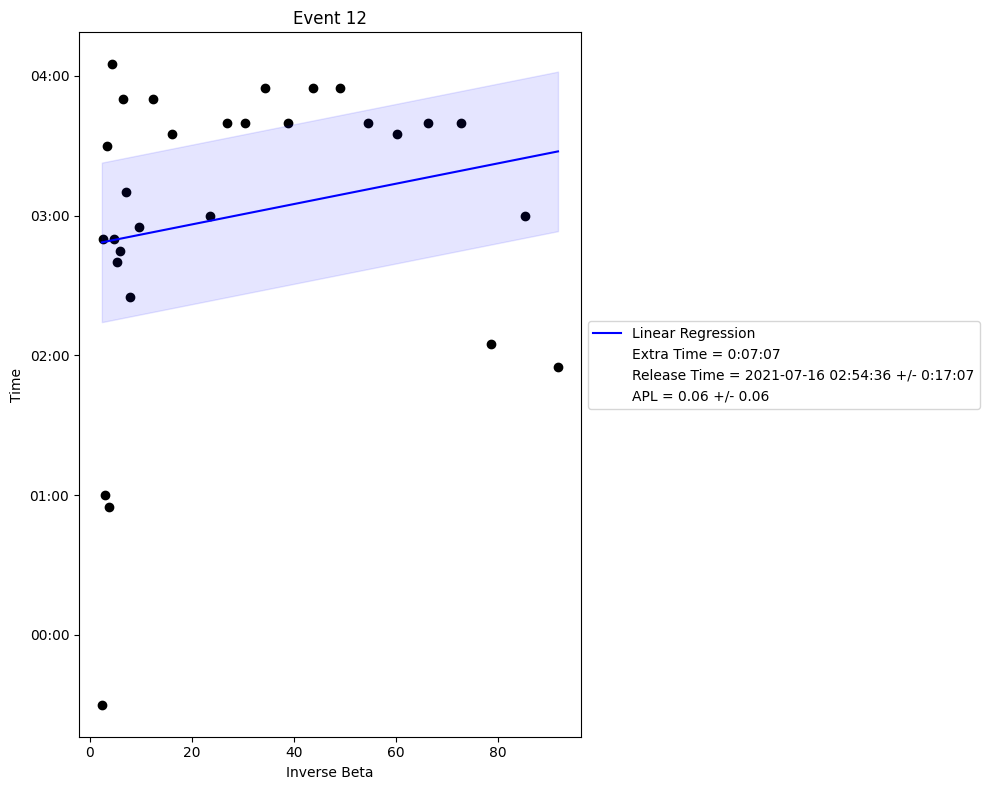

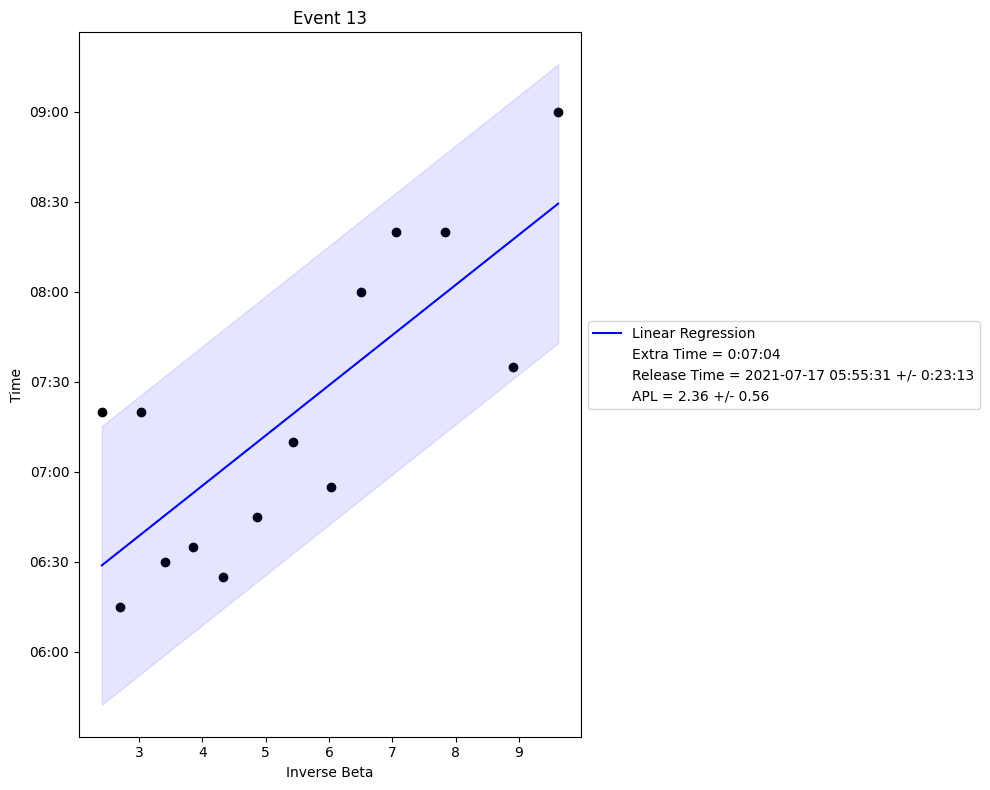

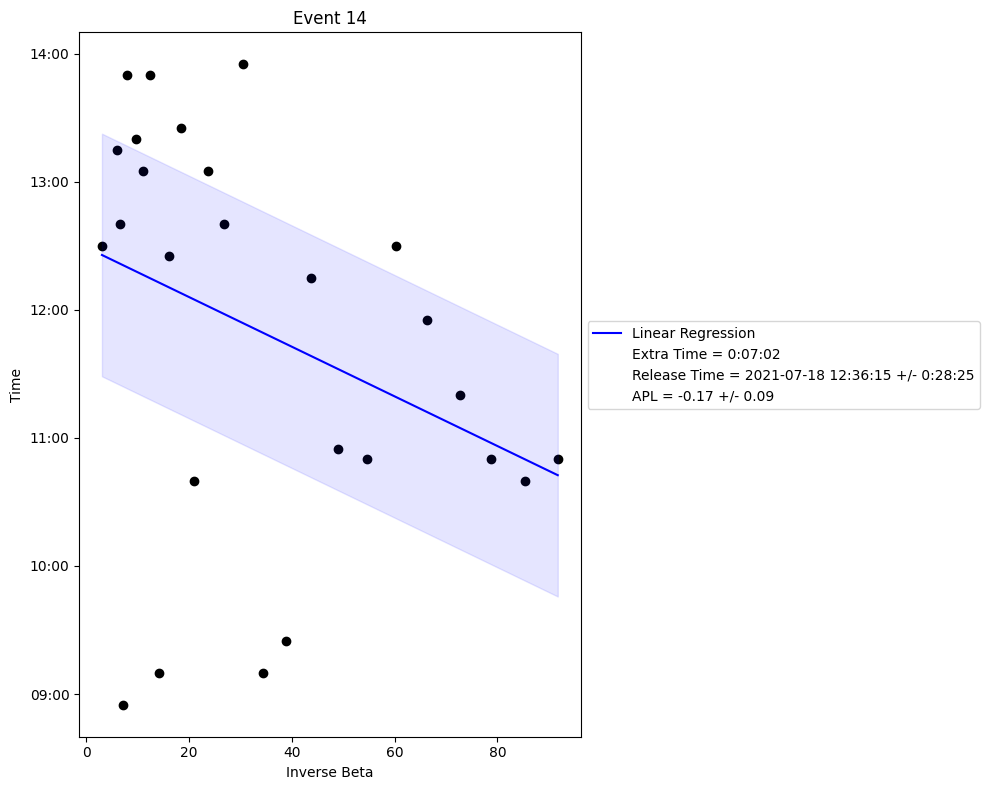

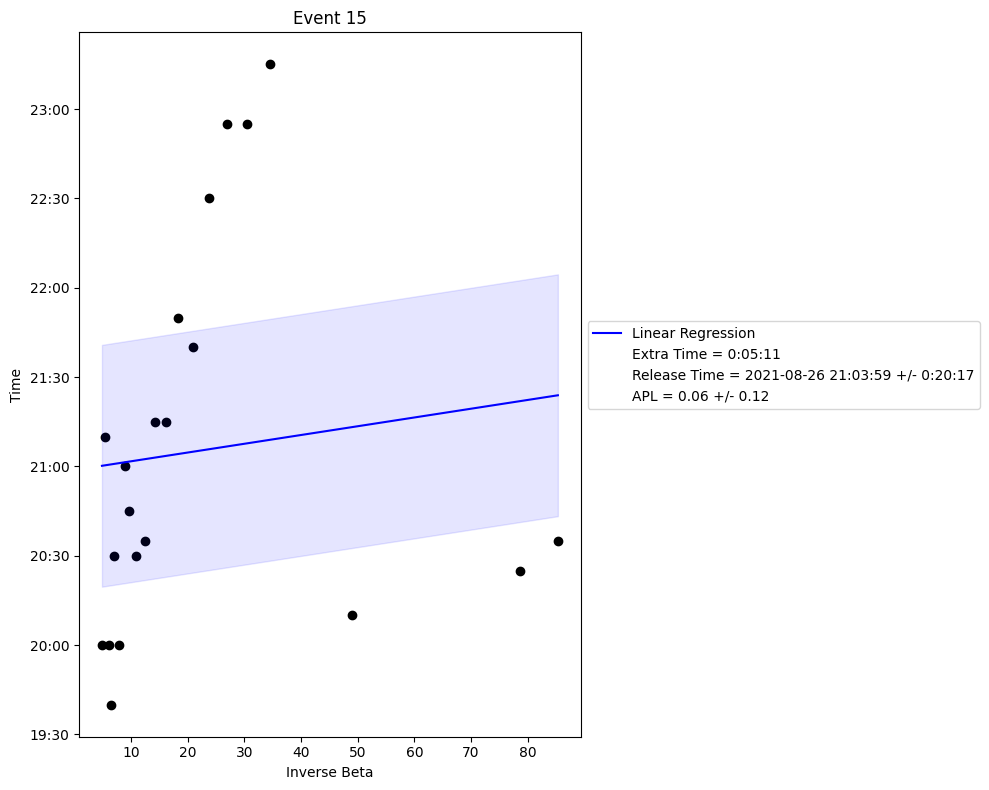

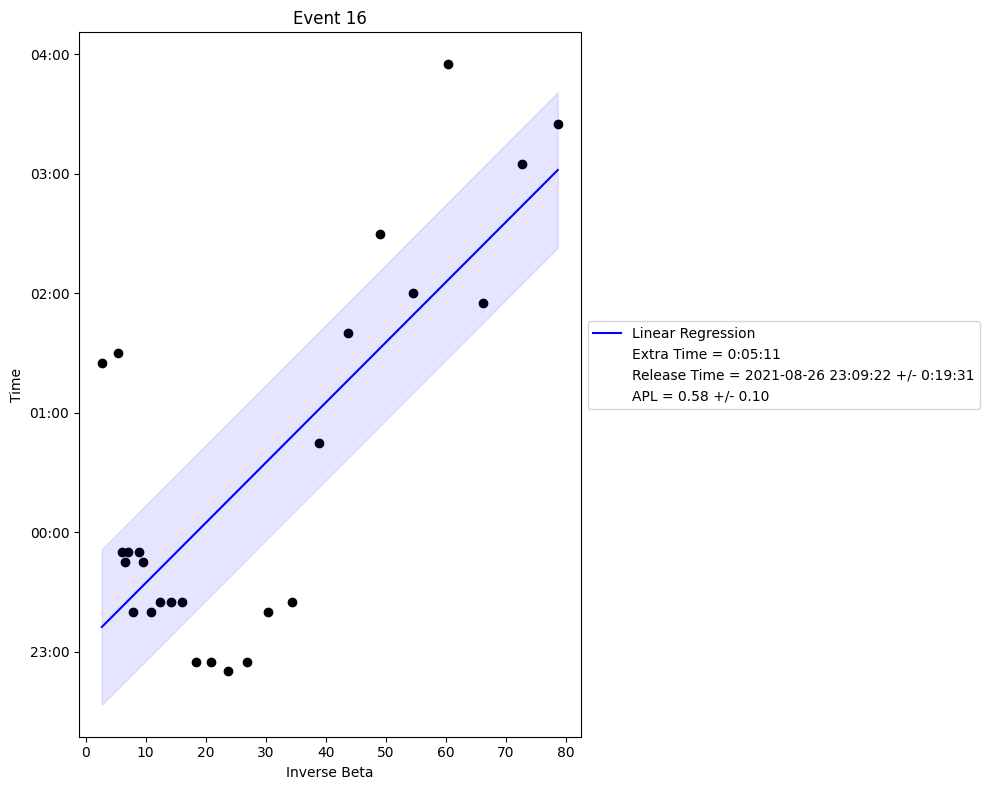

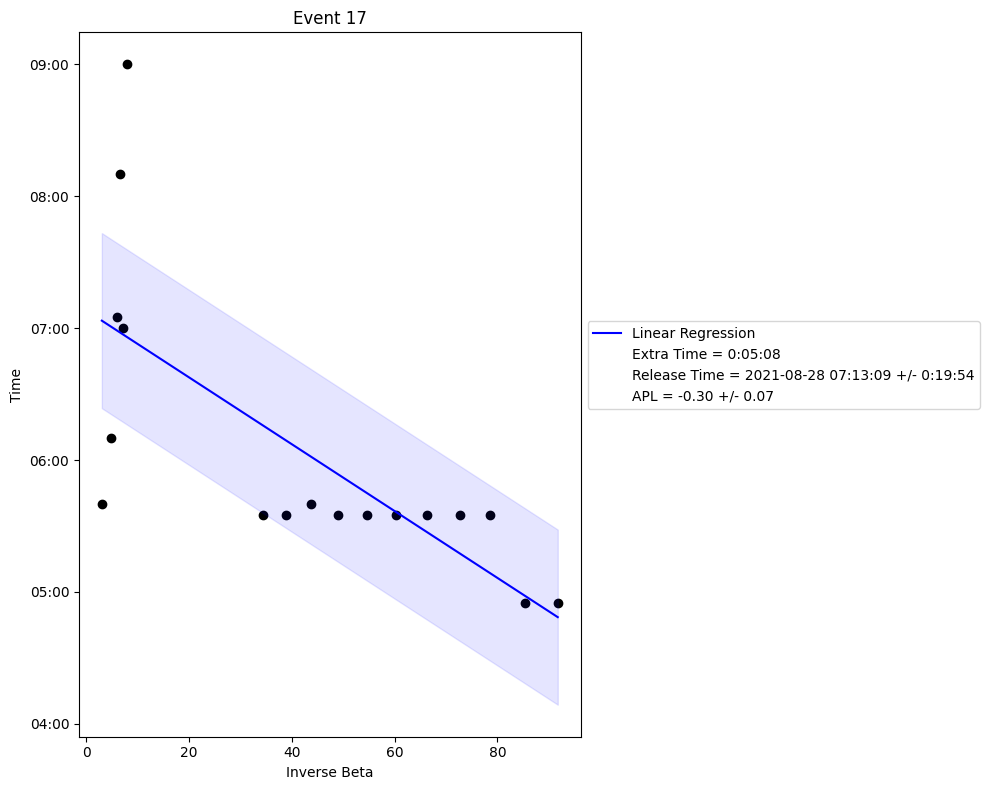

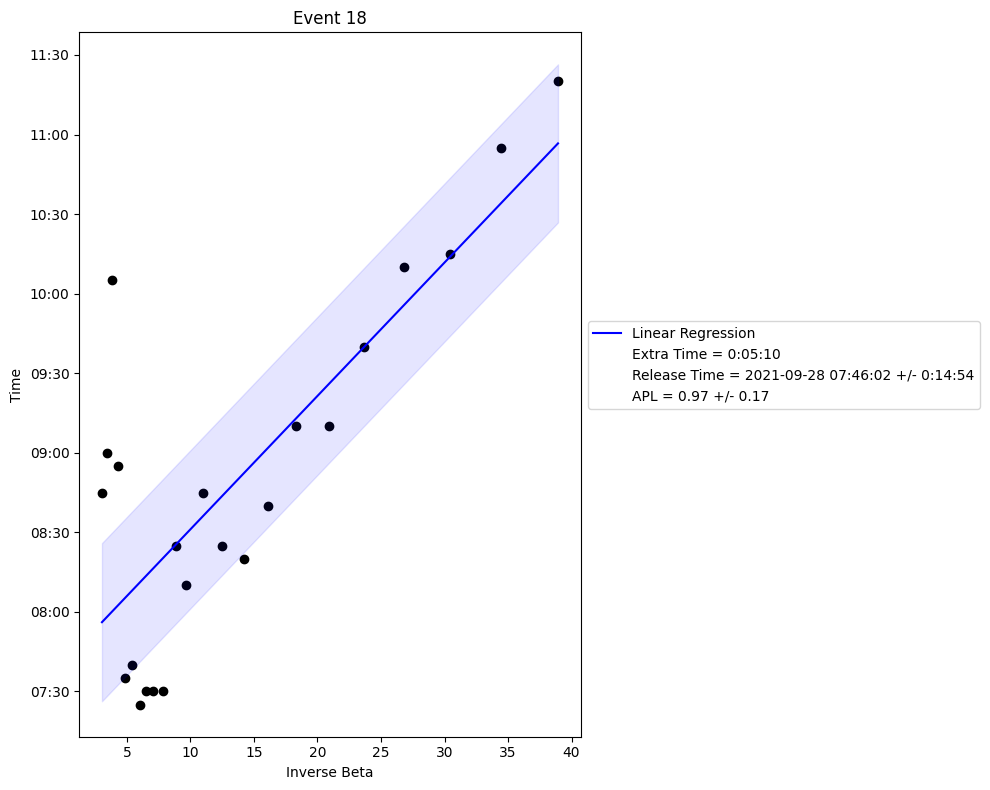

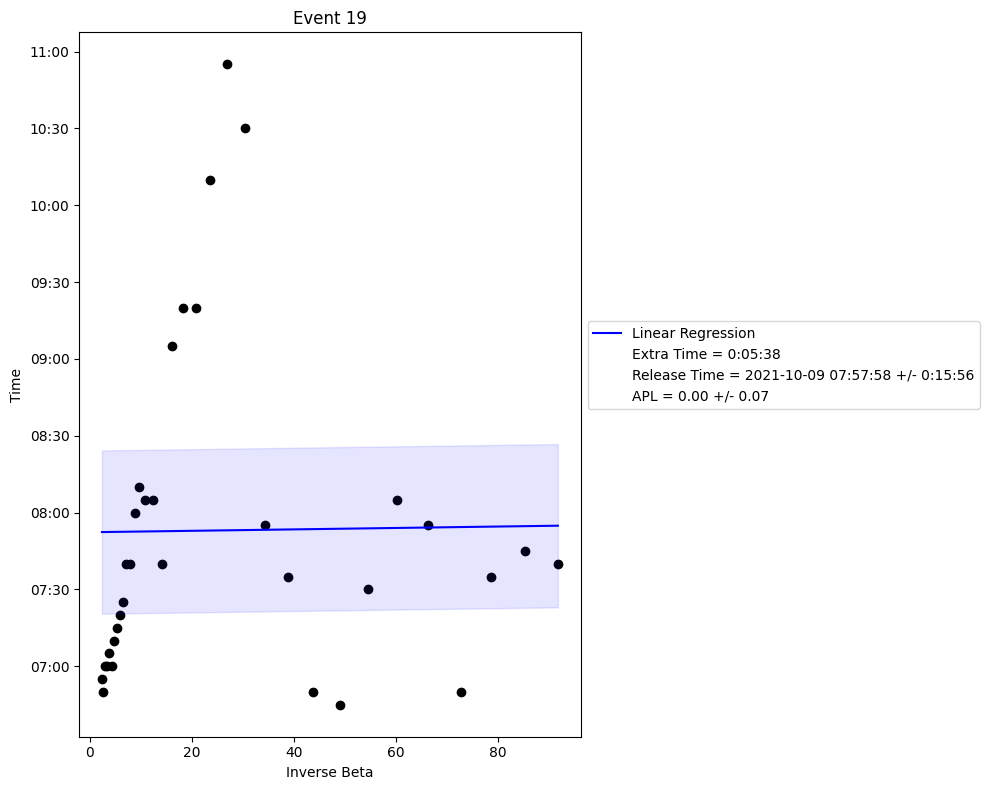

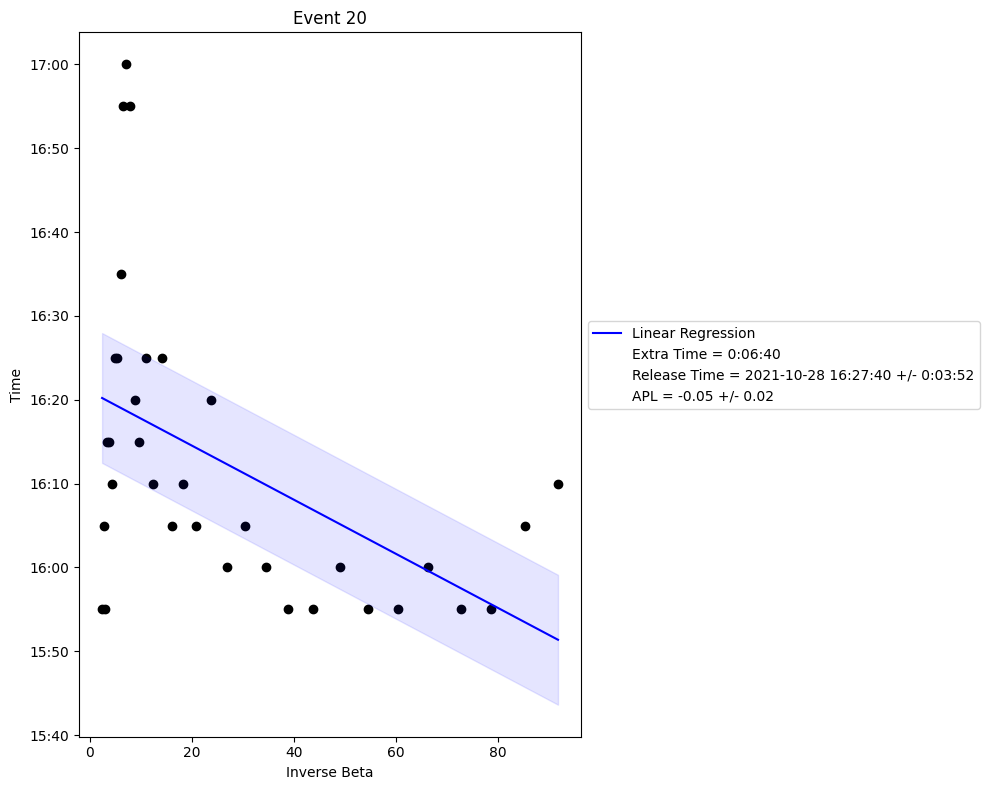

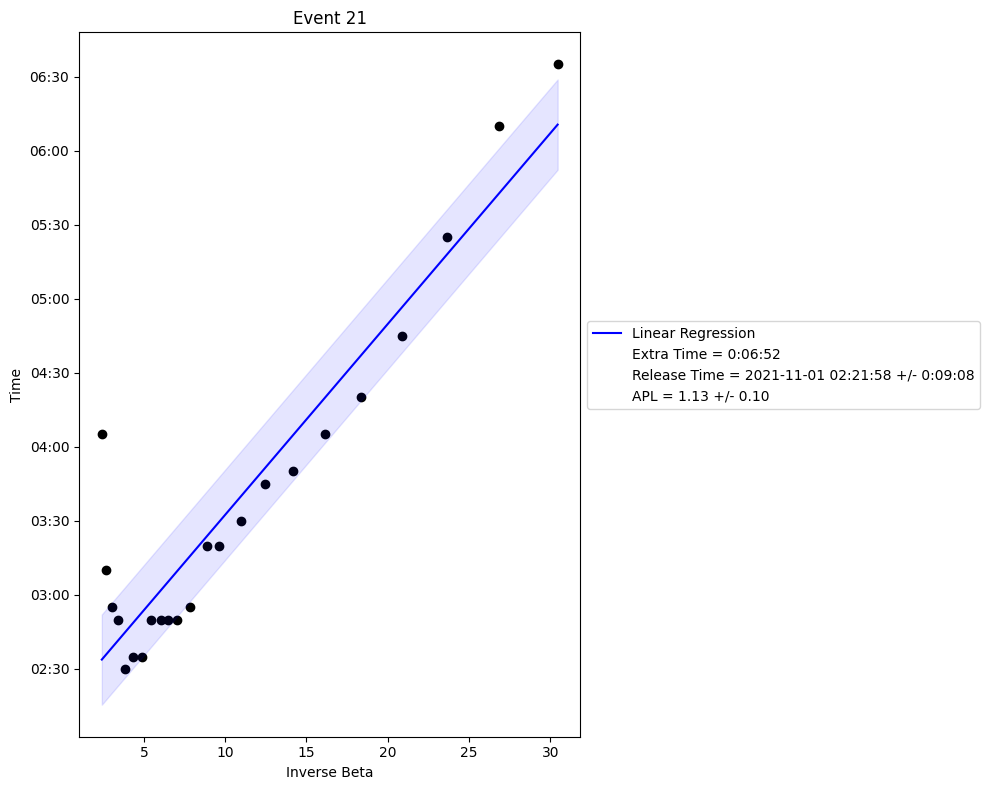

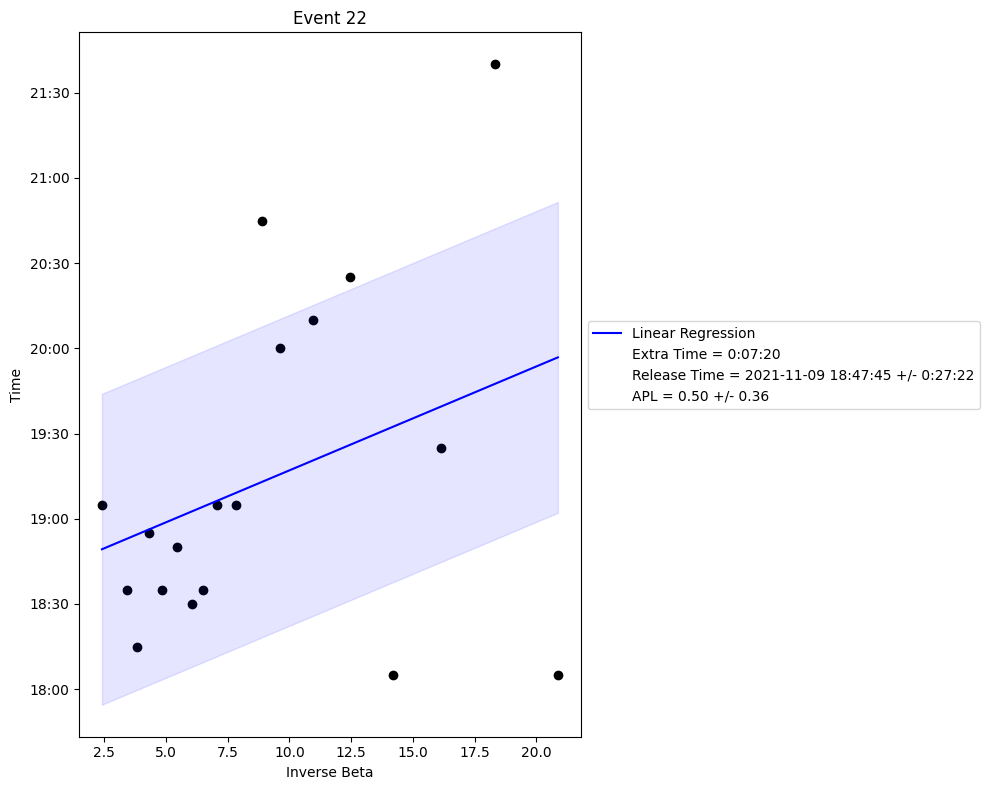

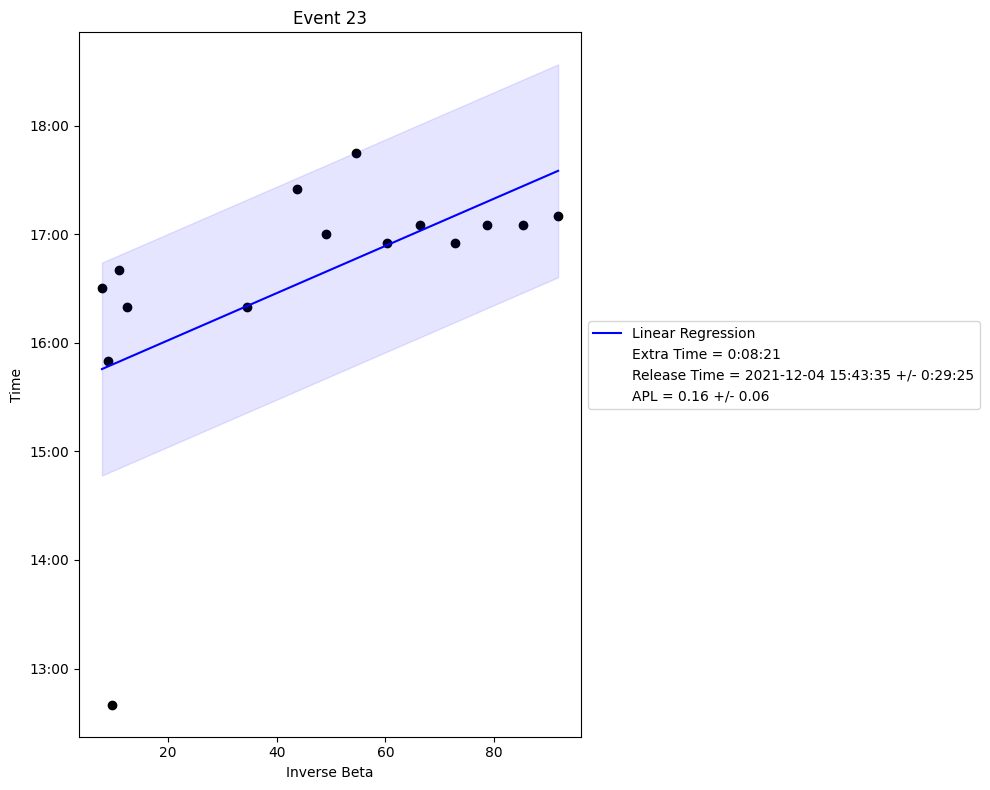

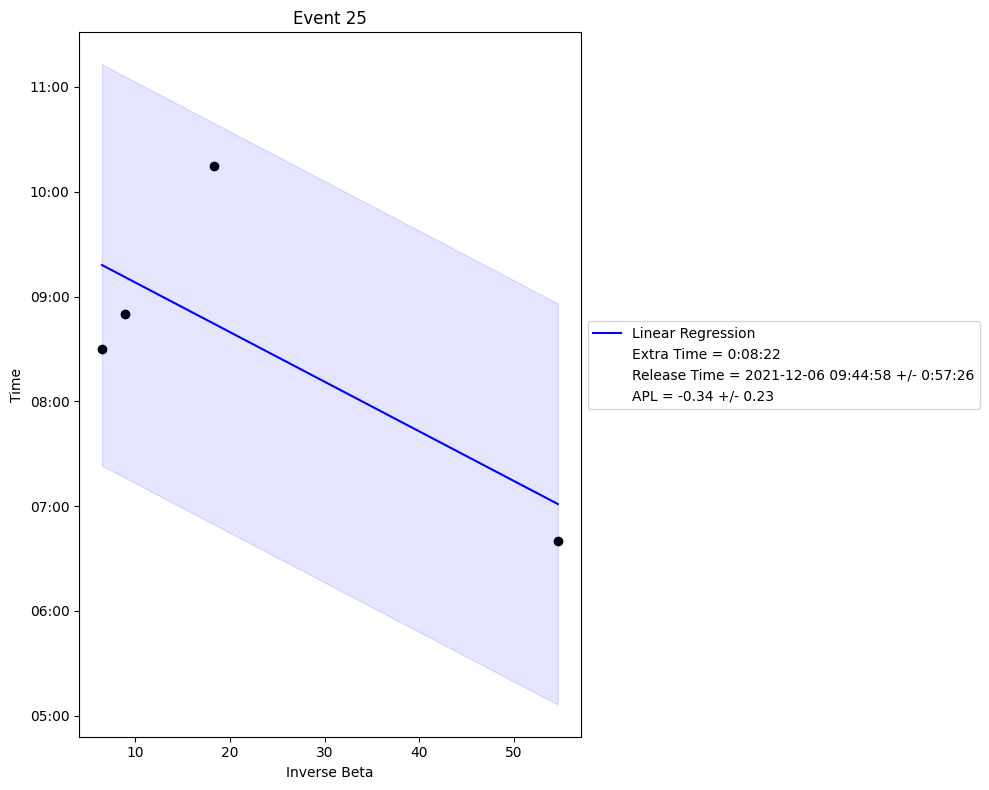

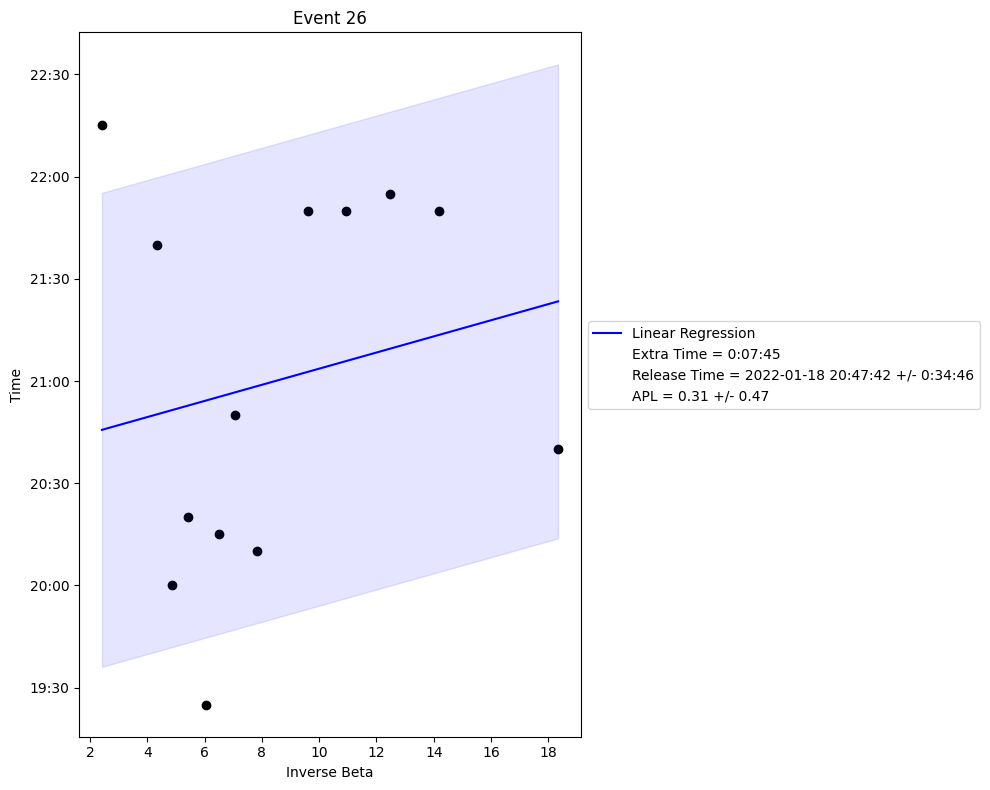

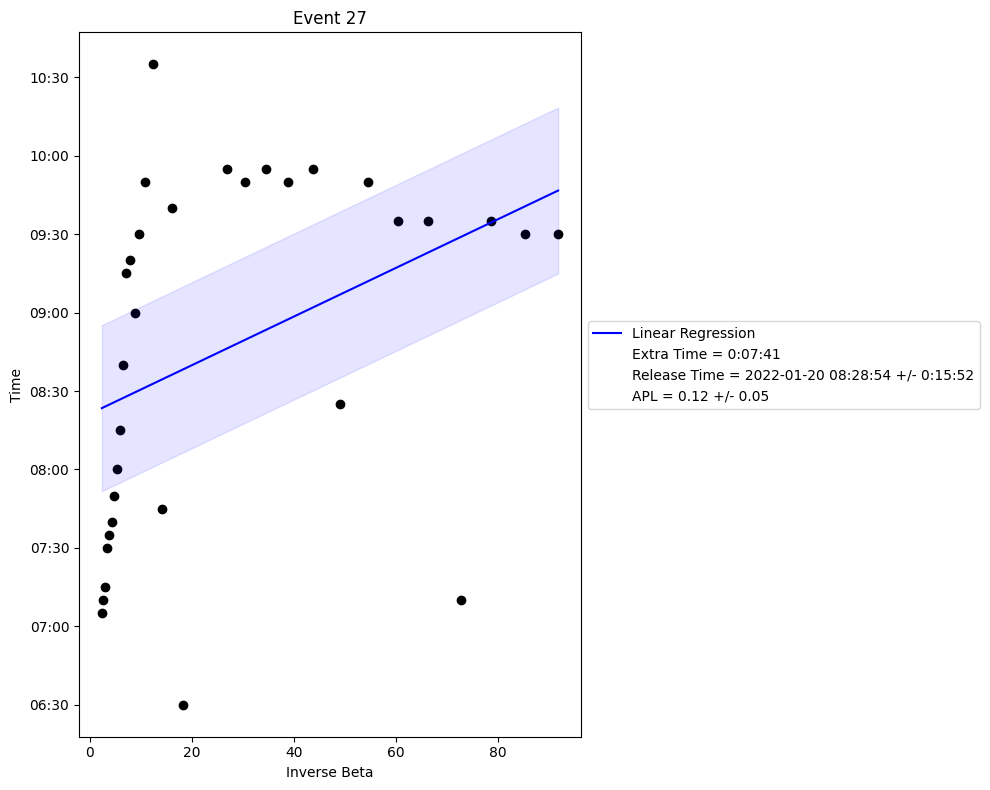

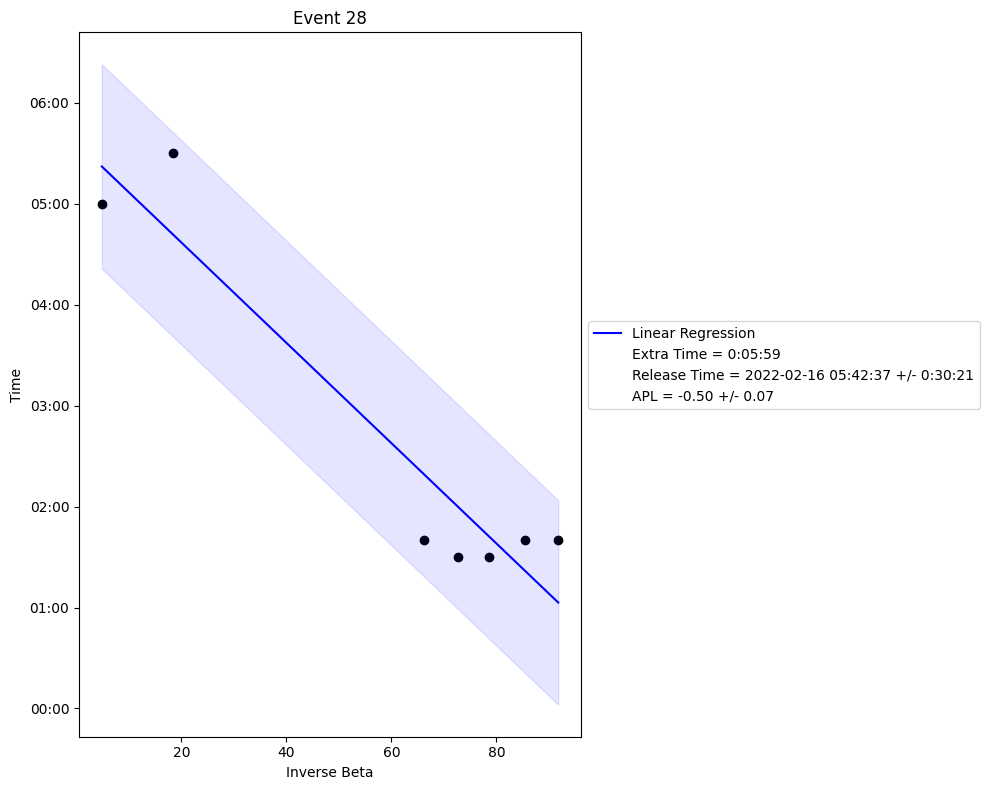

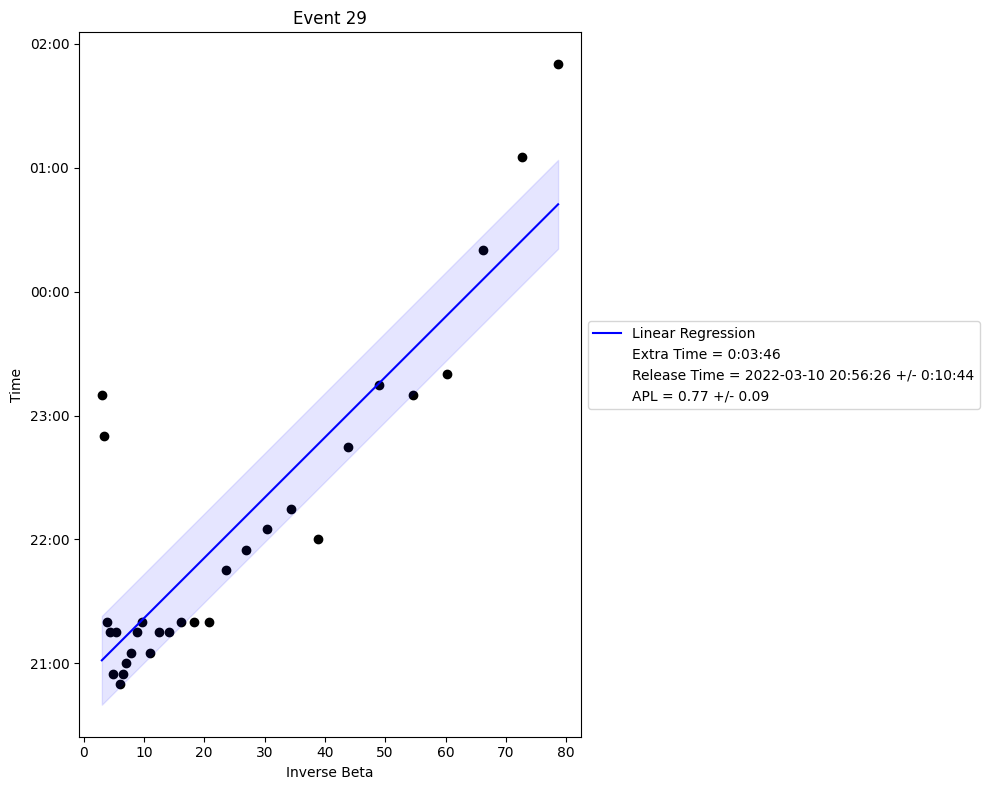

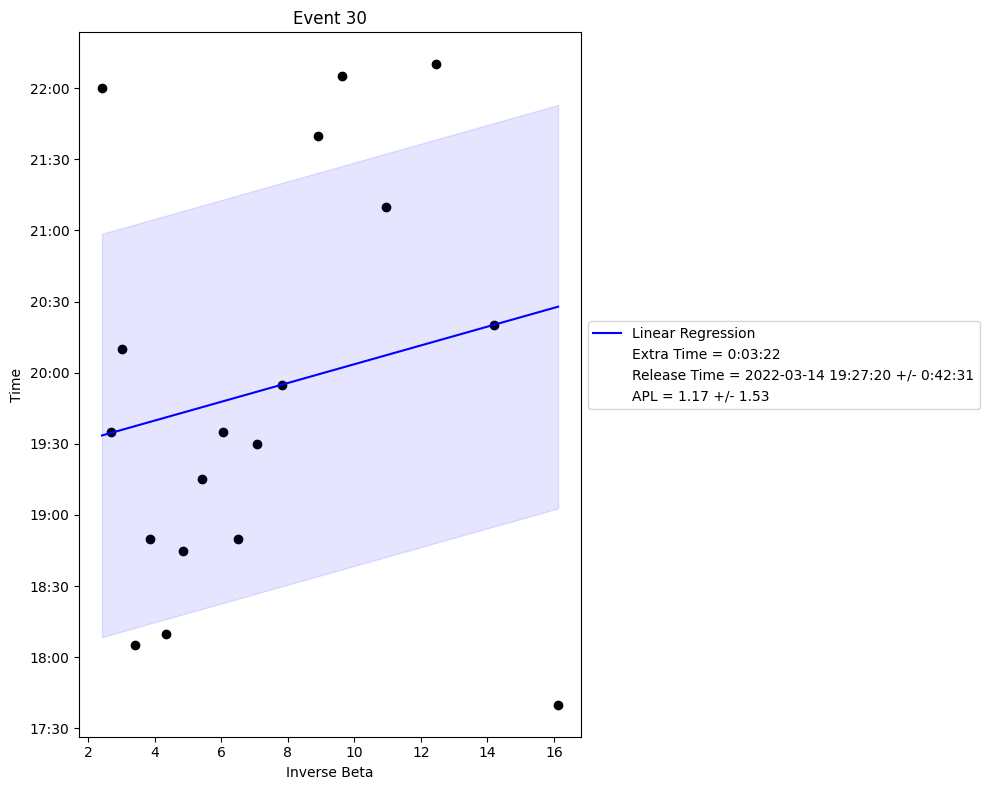

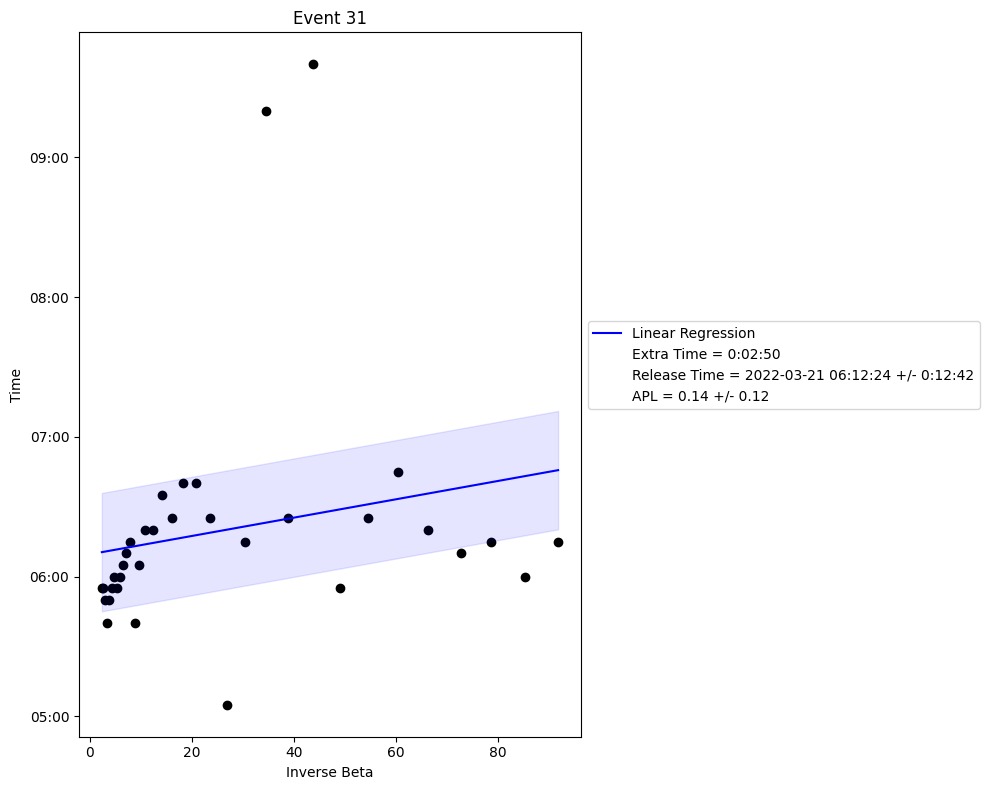

Not enough onset points in event 32.


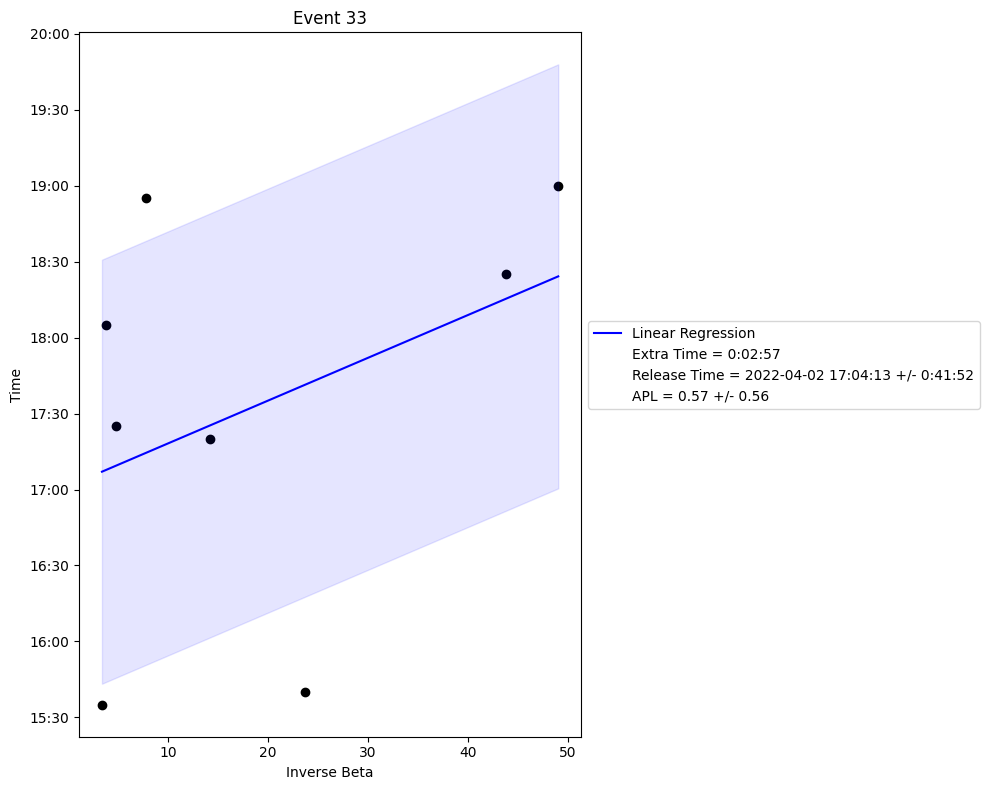

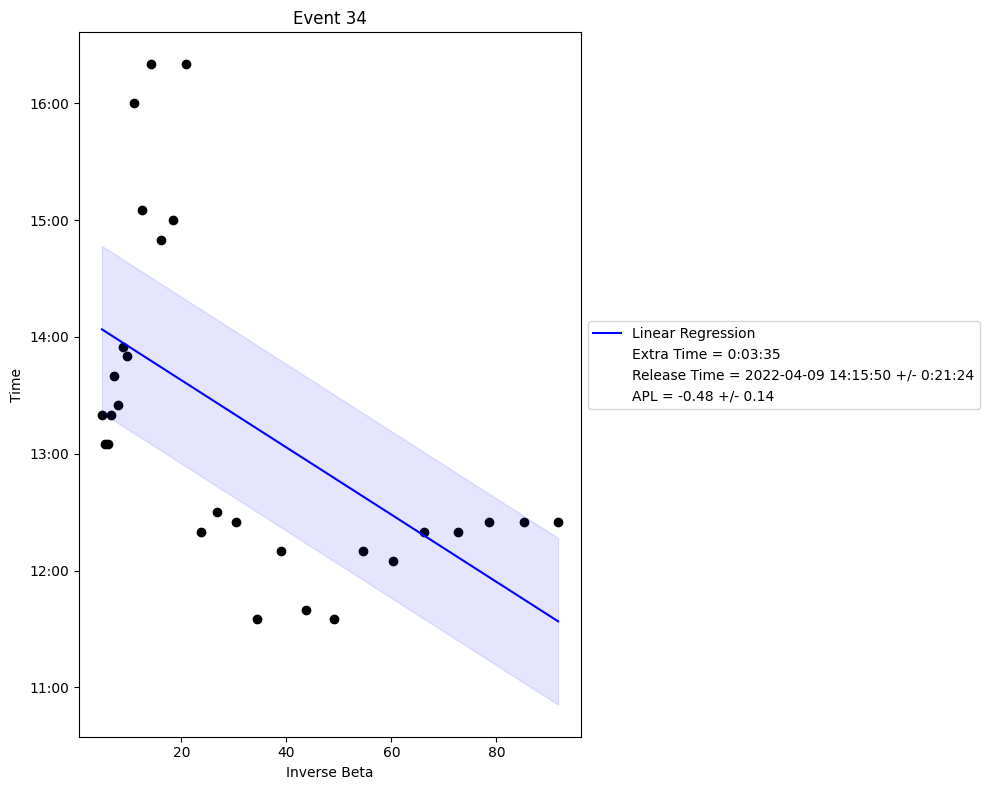

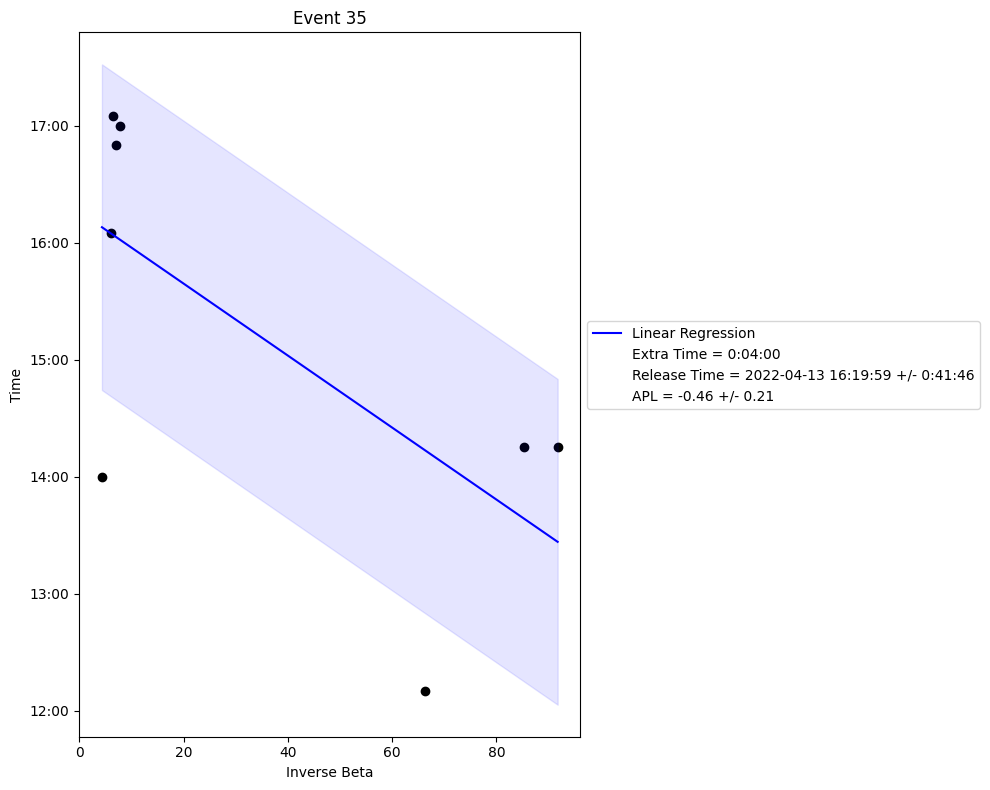

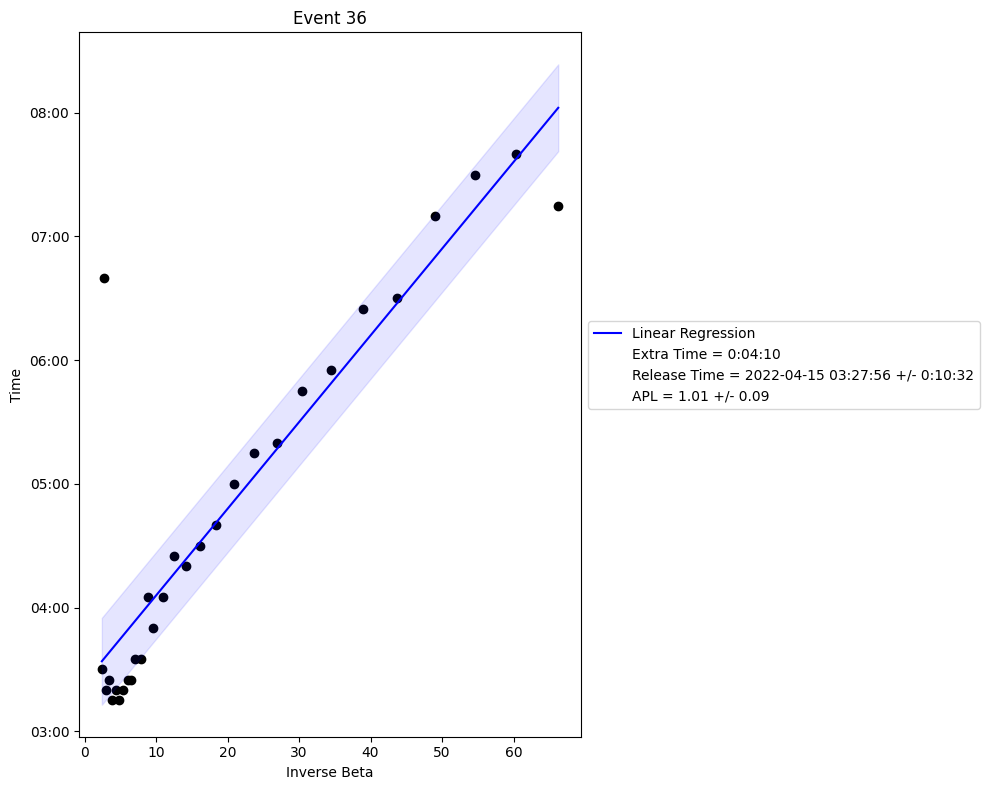

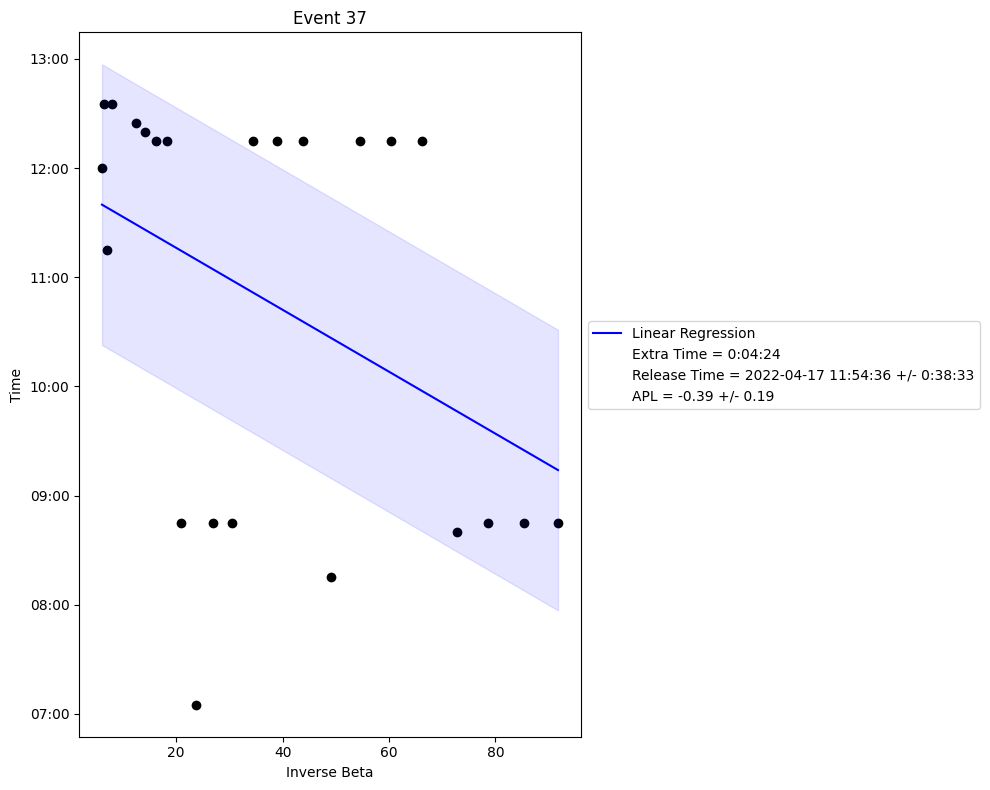

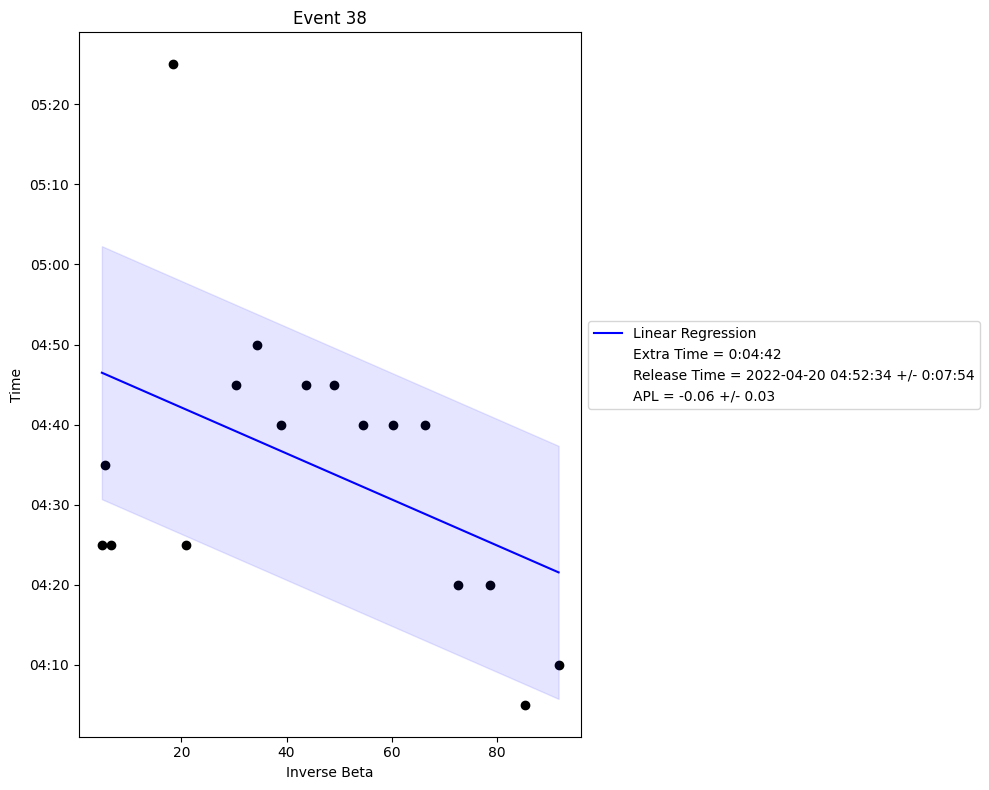

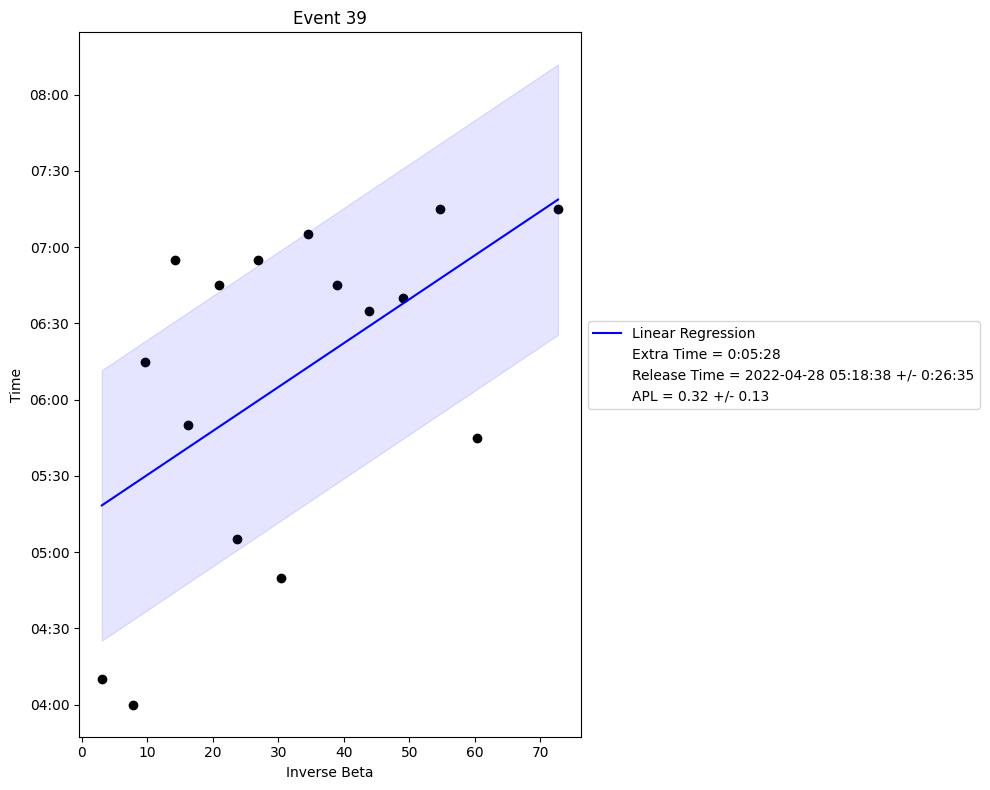

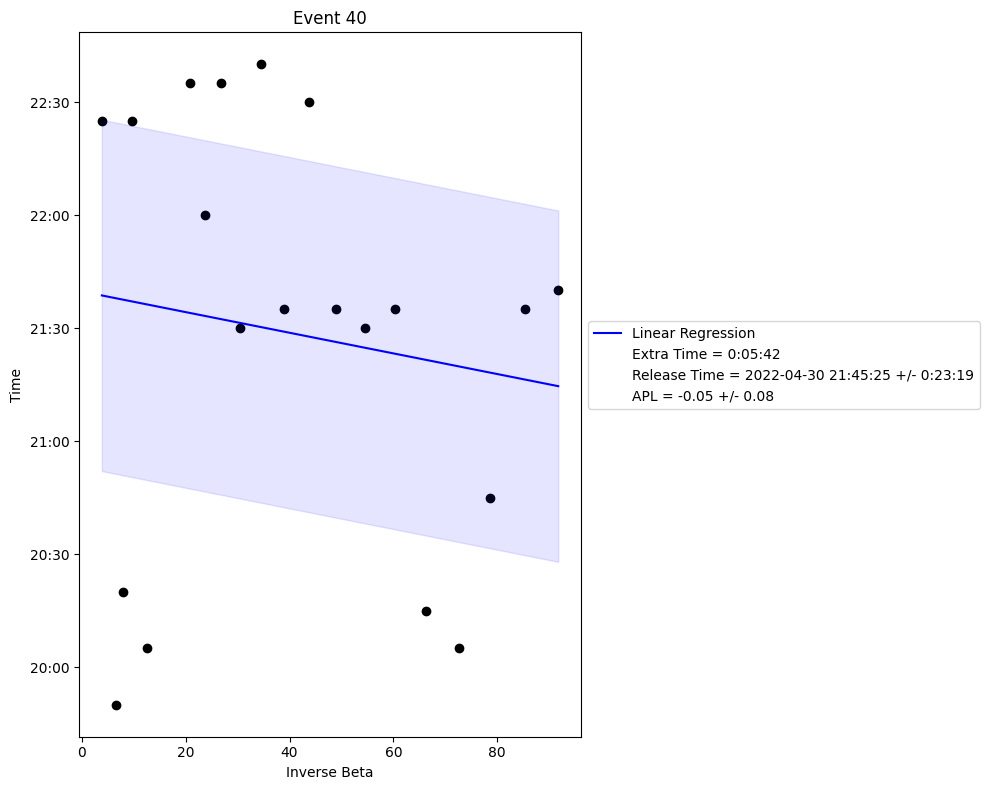

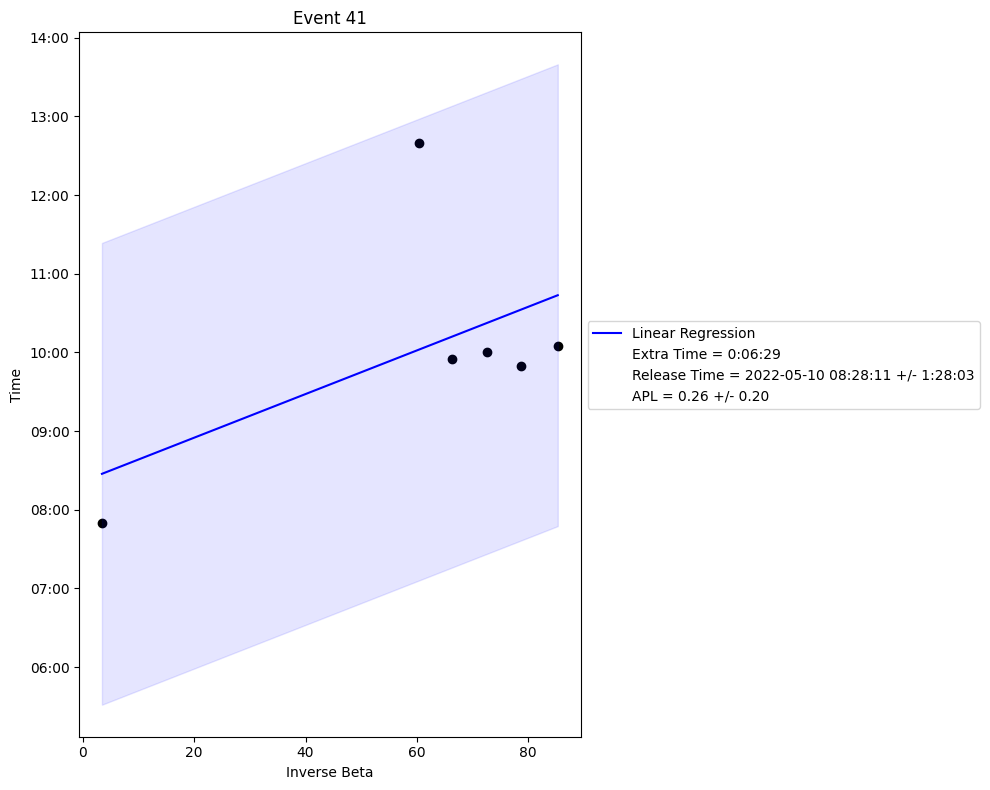

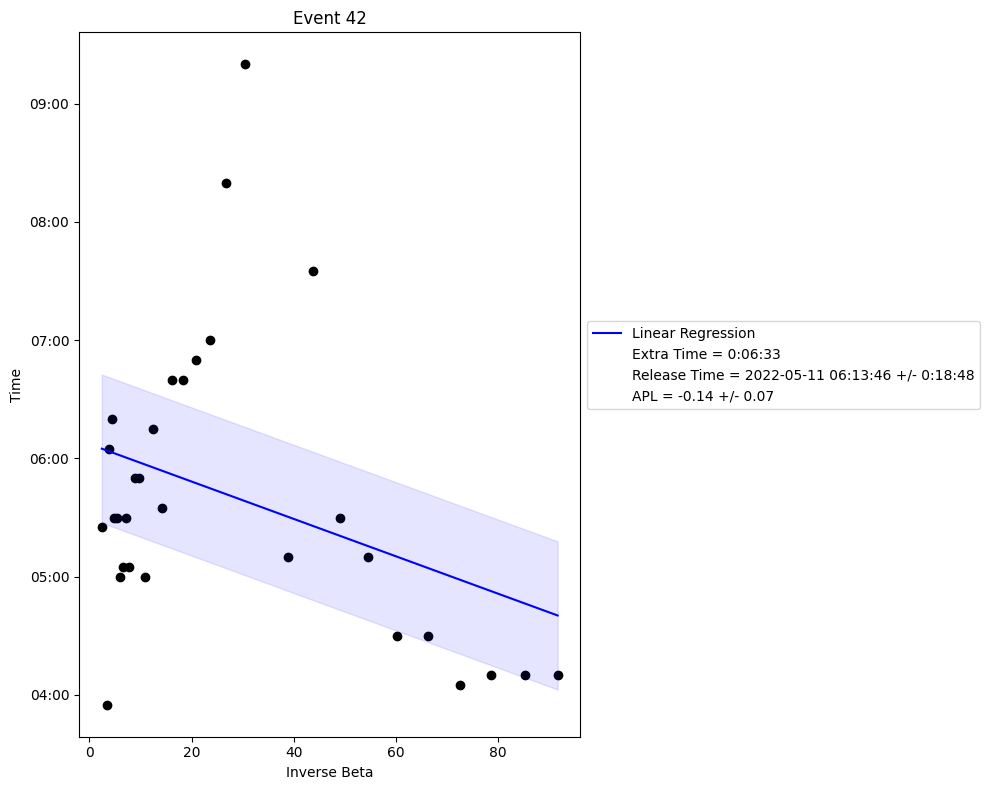

Not enough points for covariance matrix generation in event 43


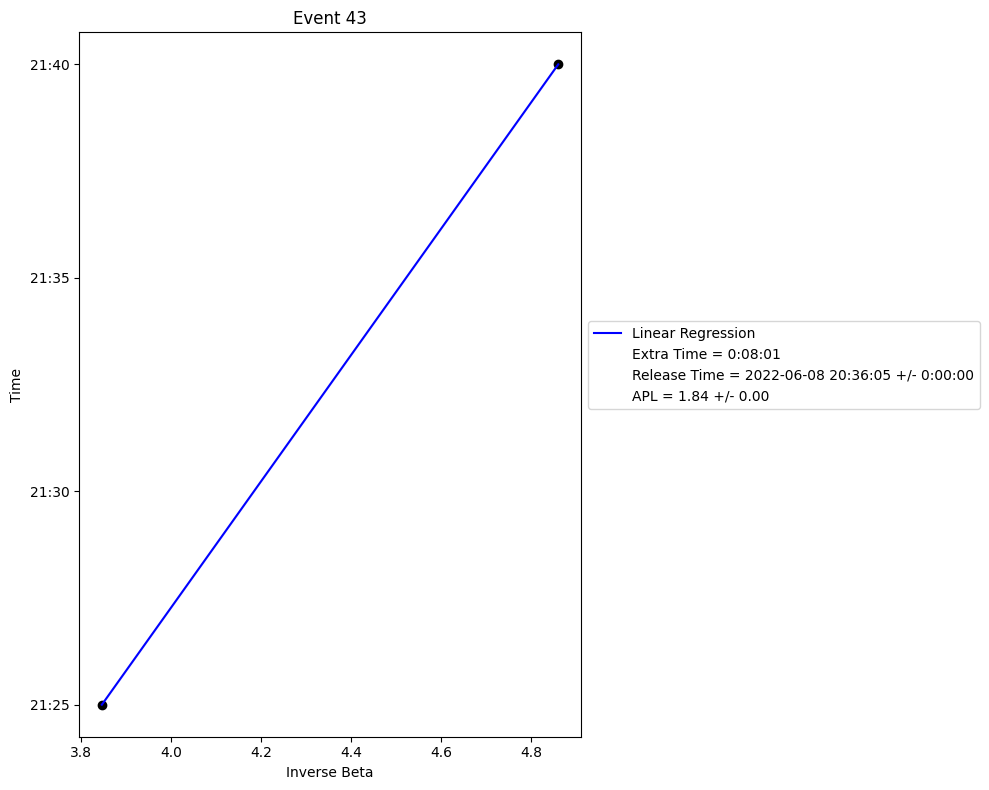

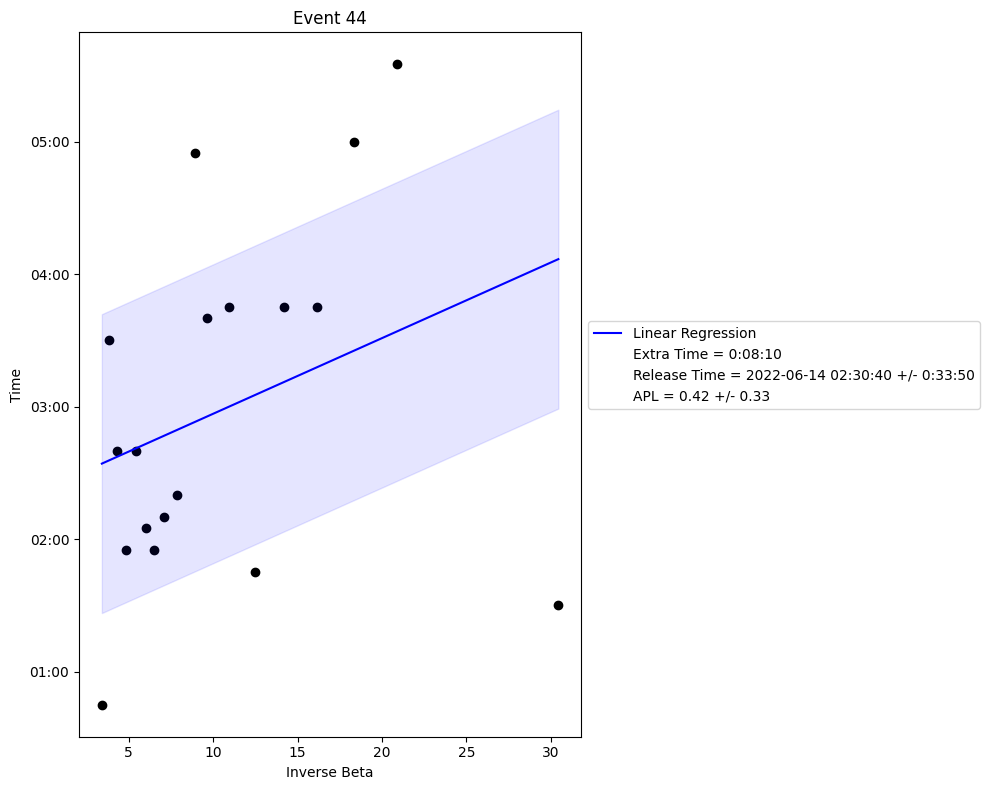

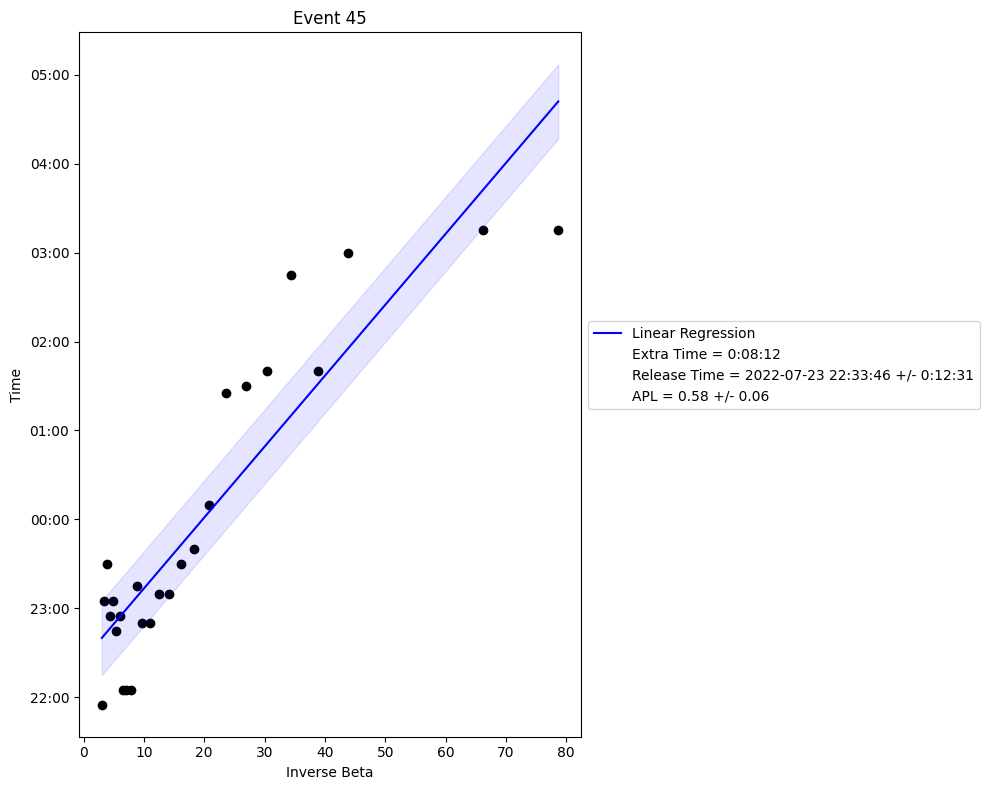

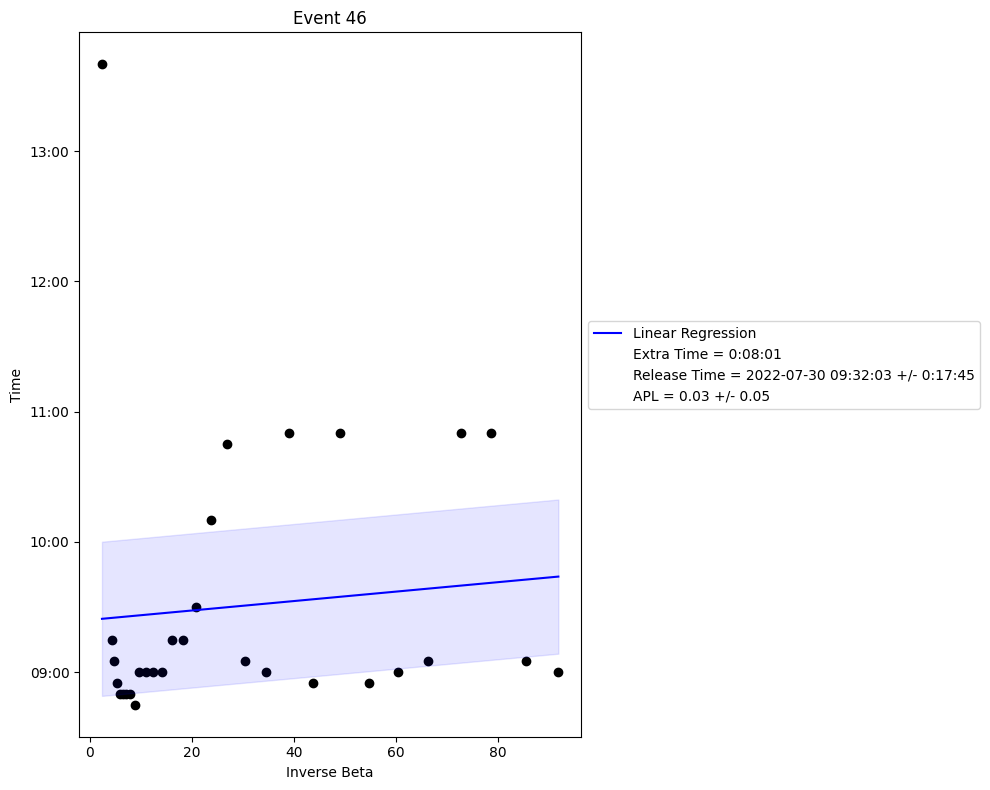

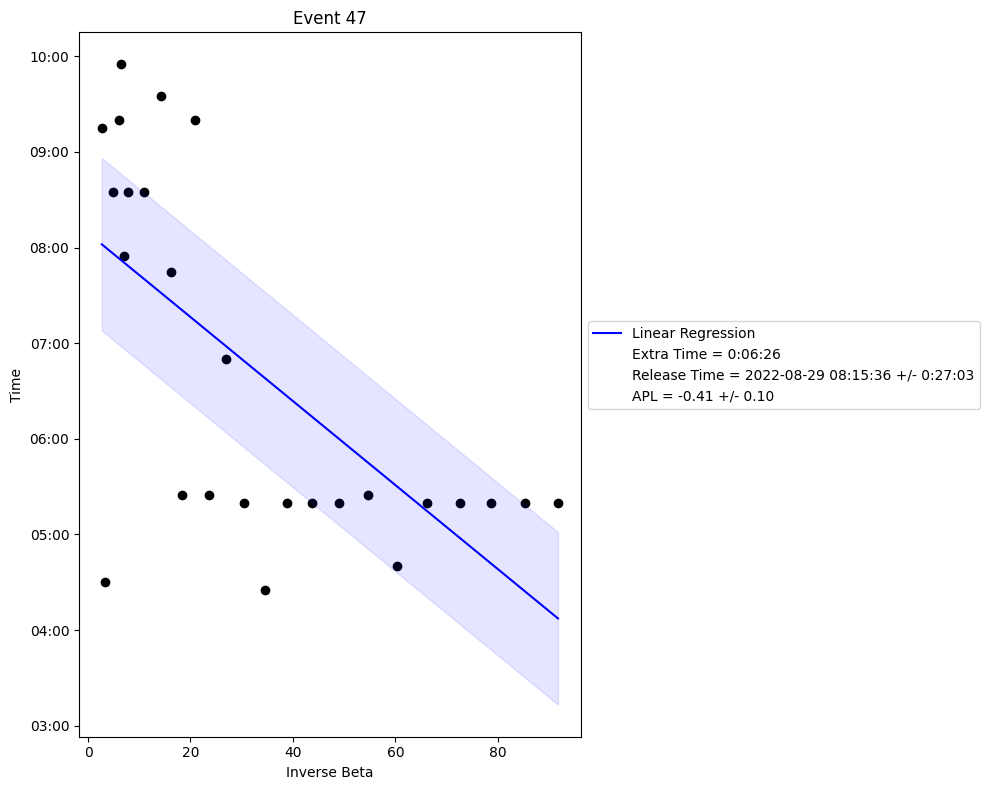

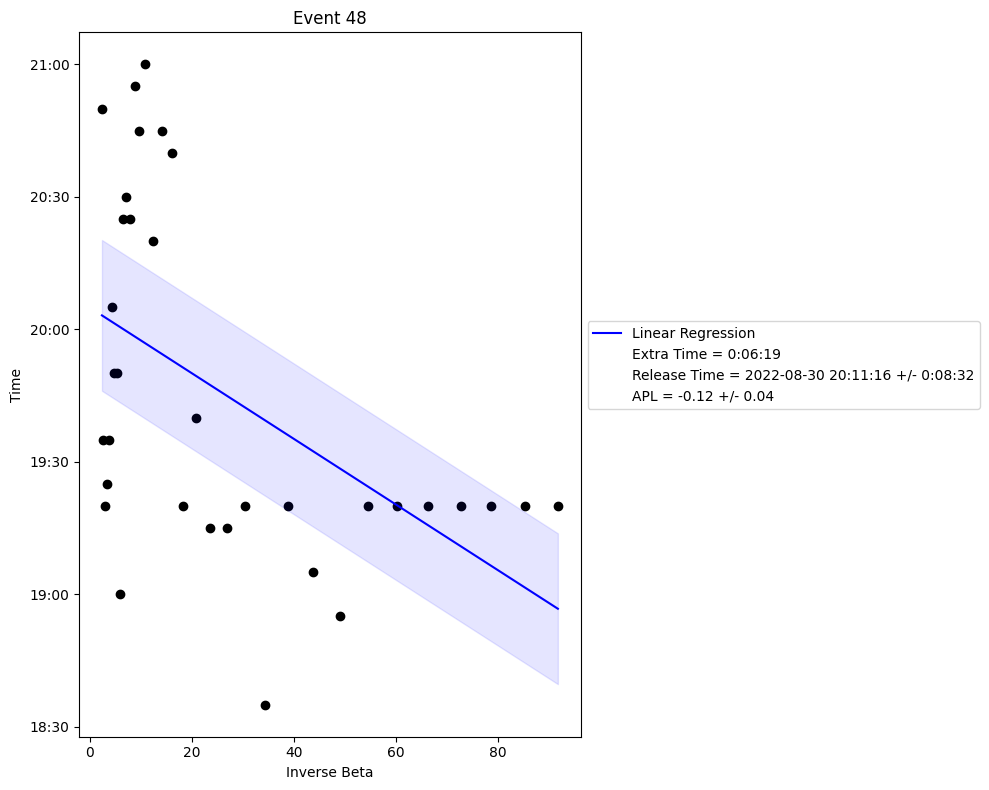

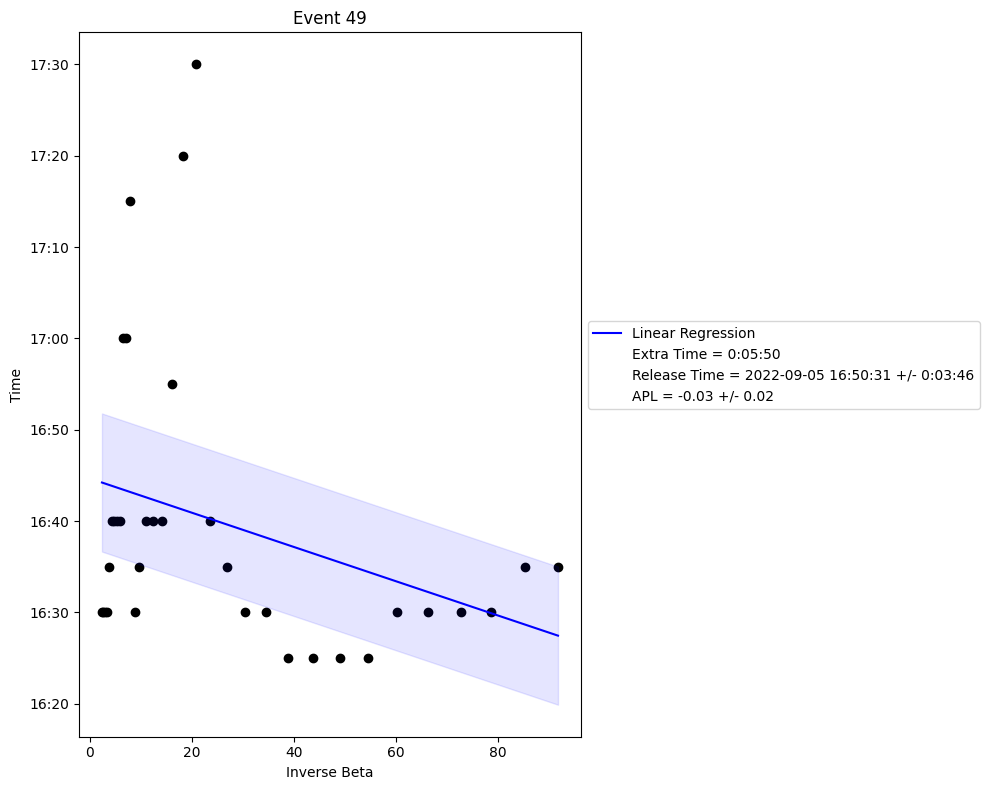

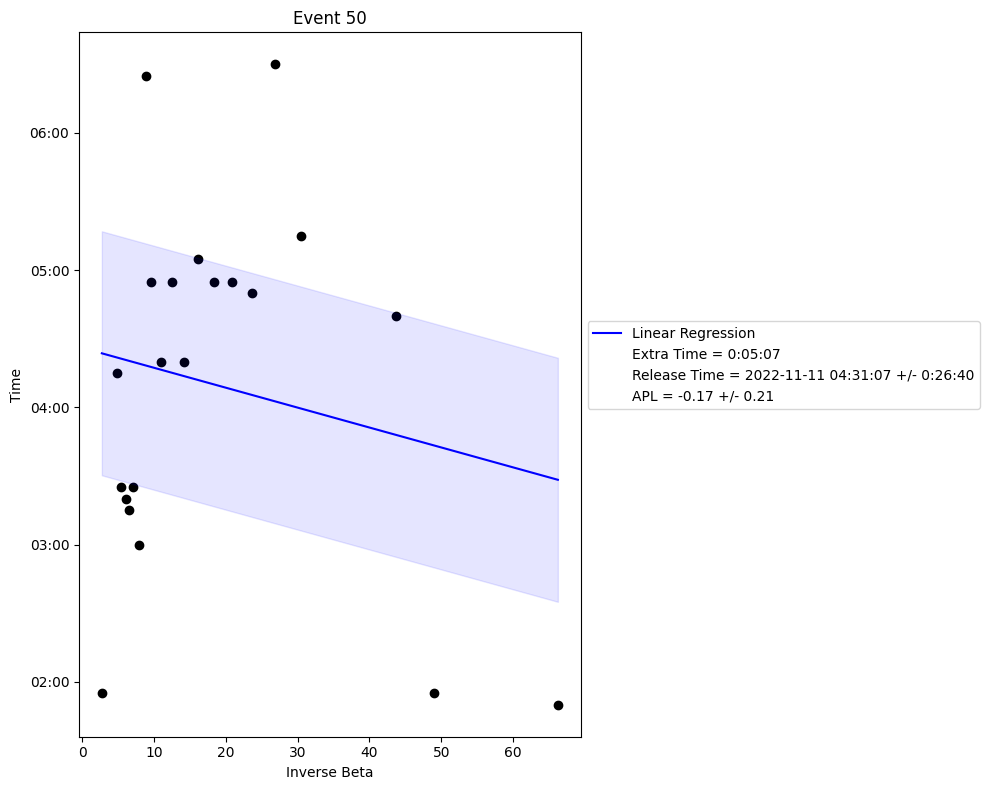

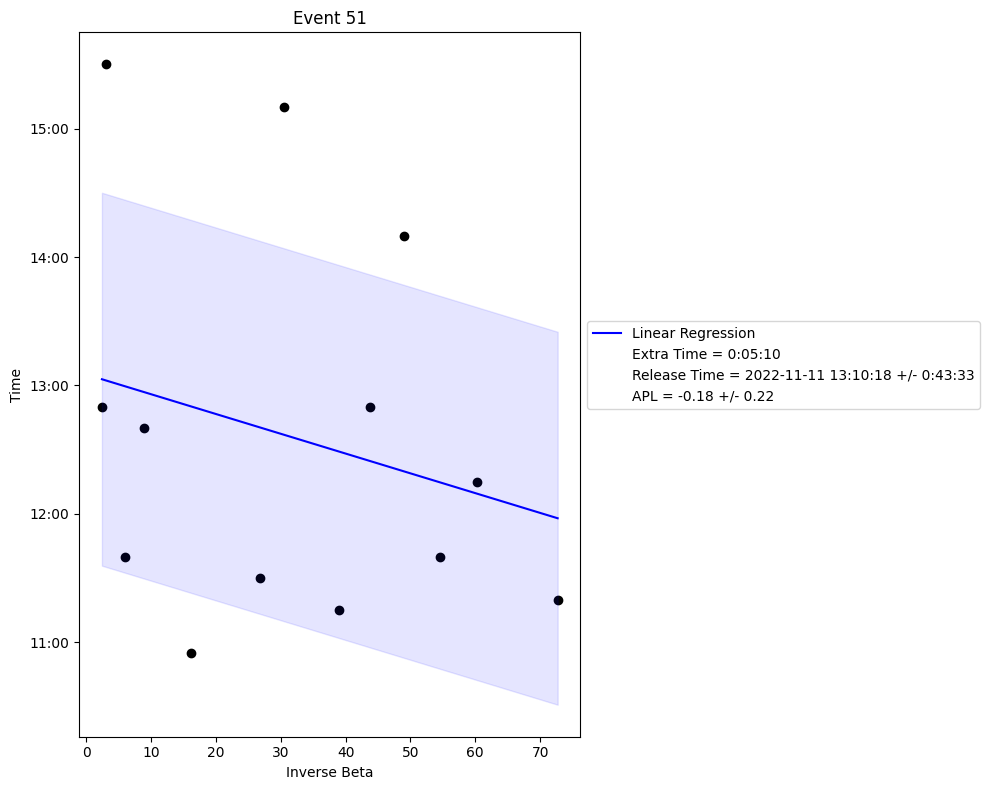

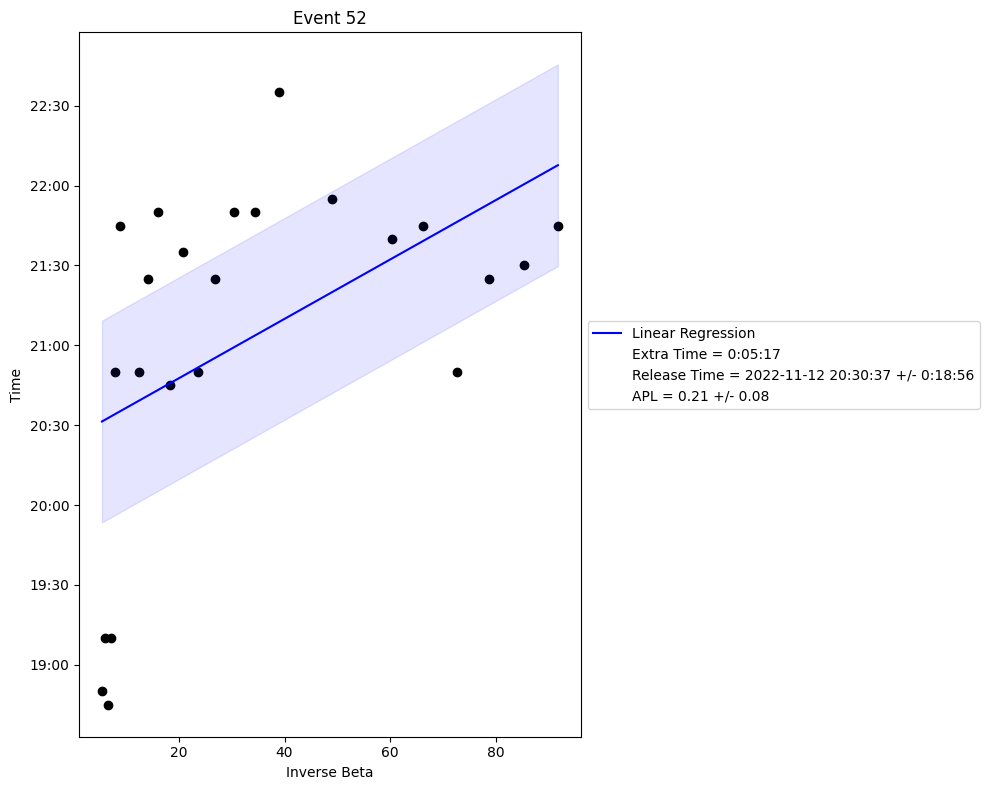

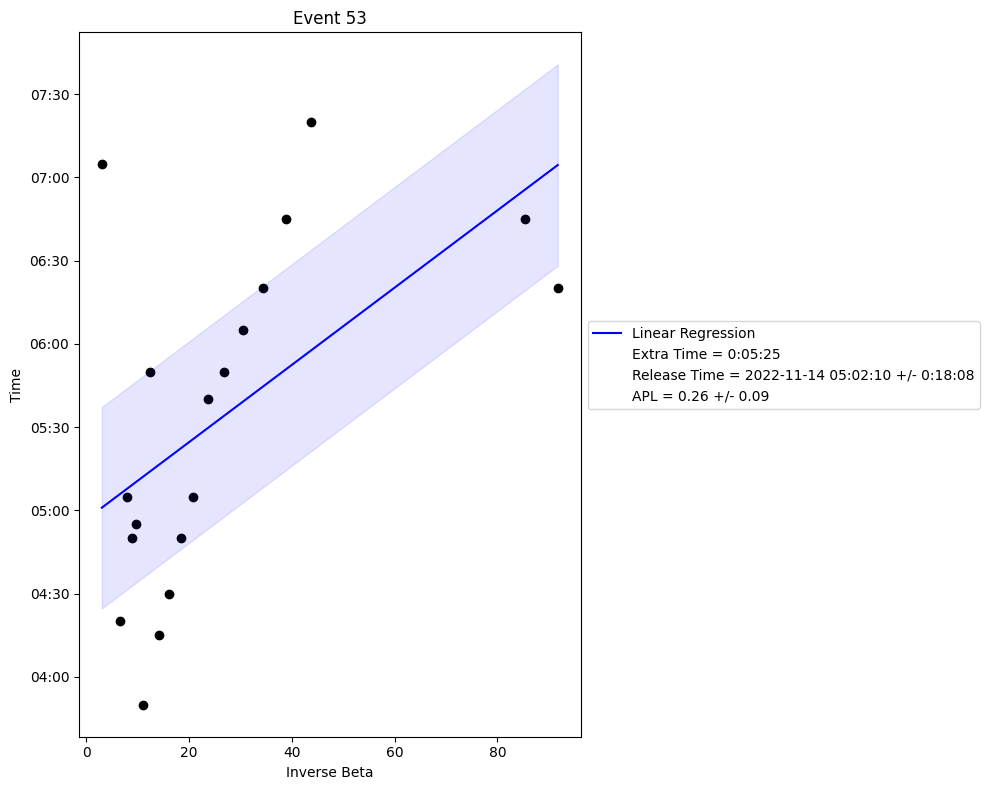

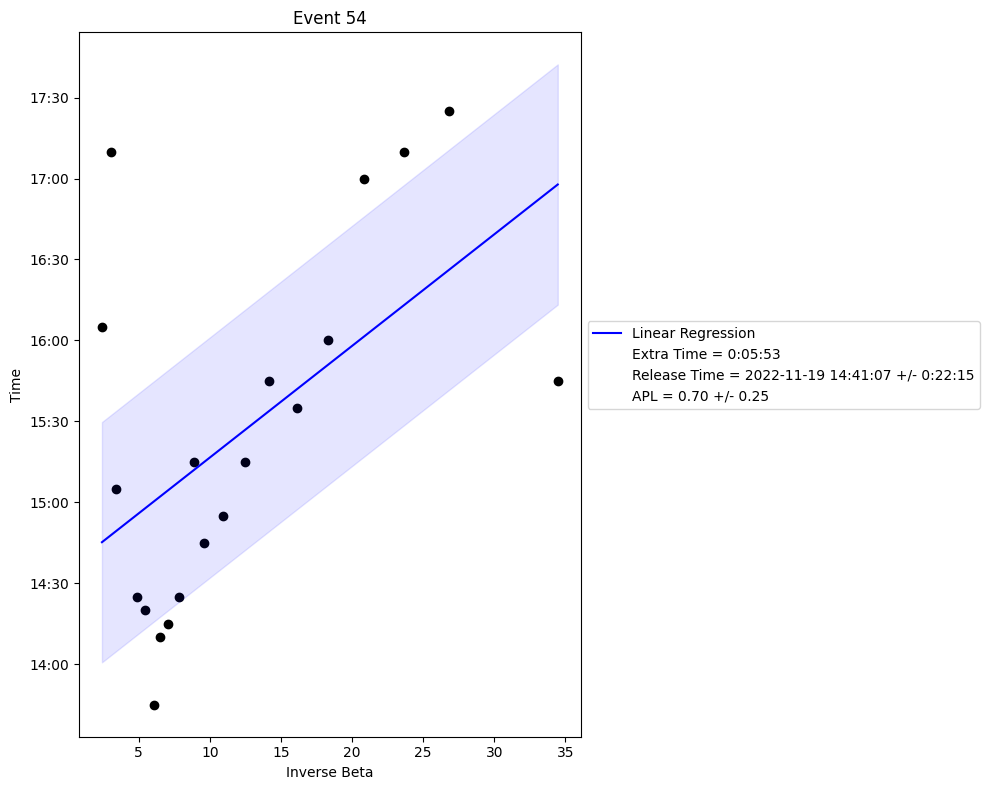

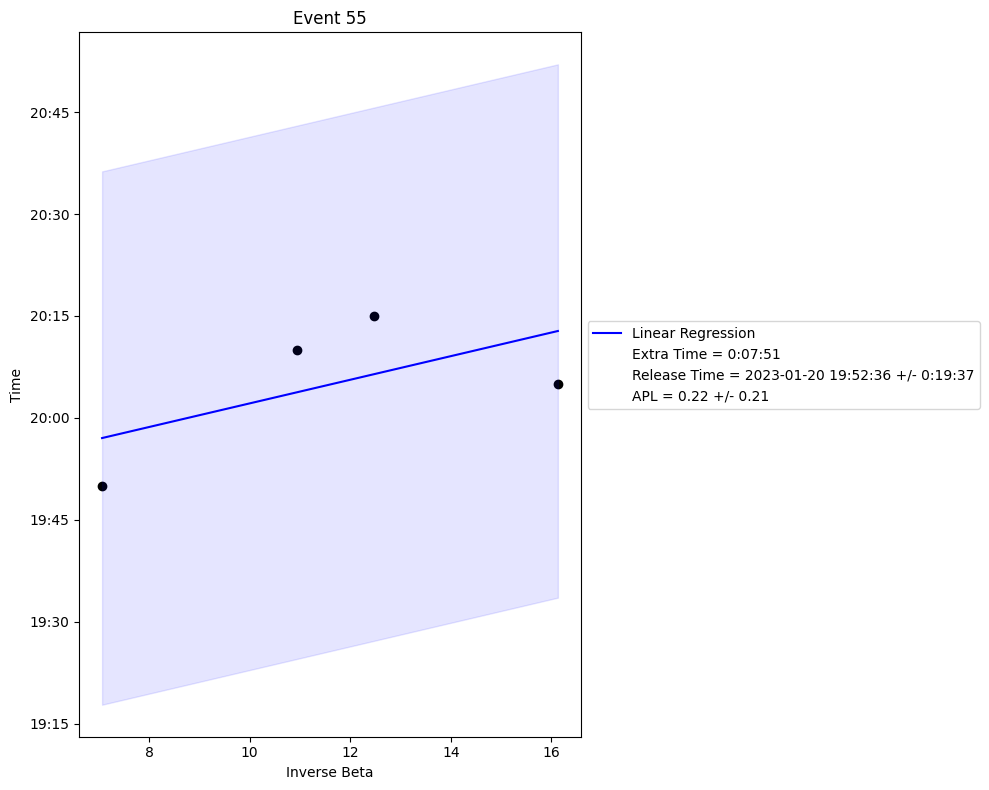

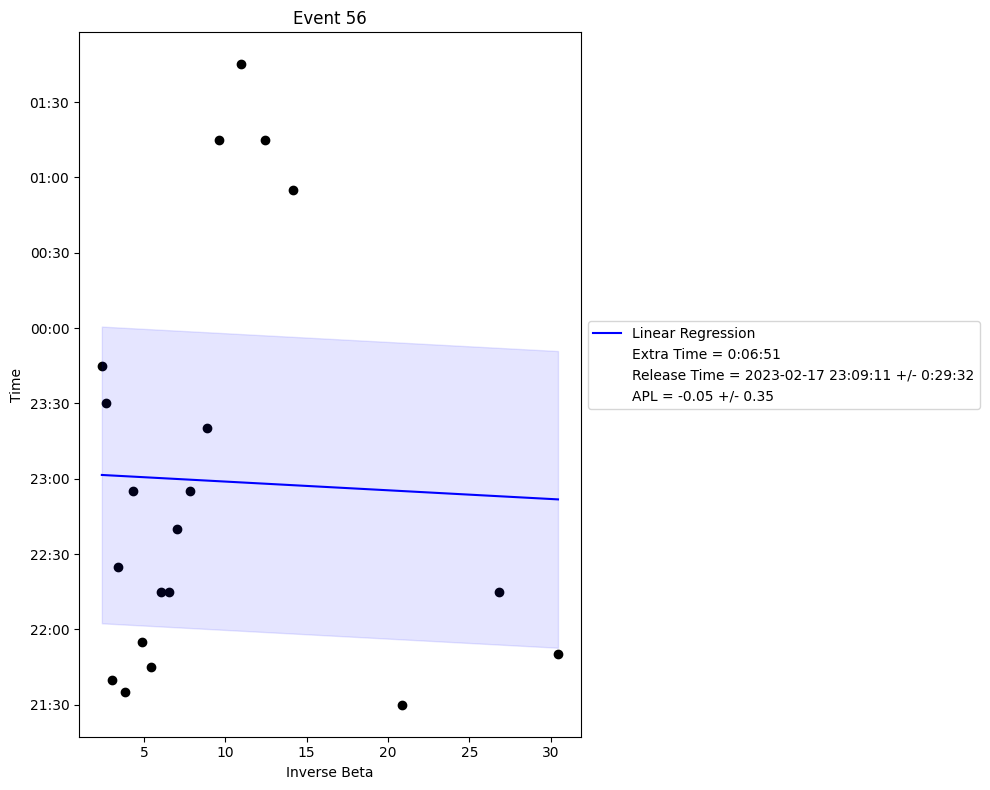

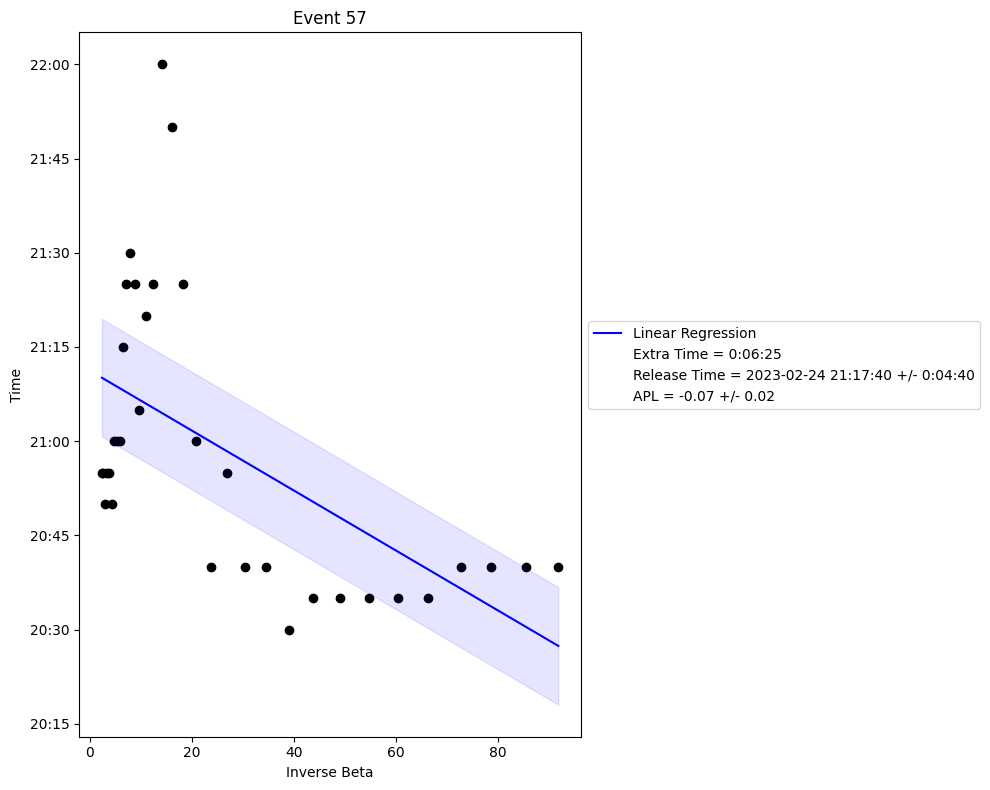

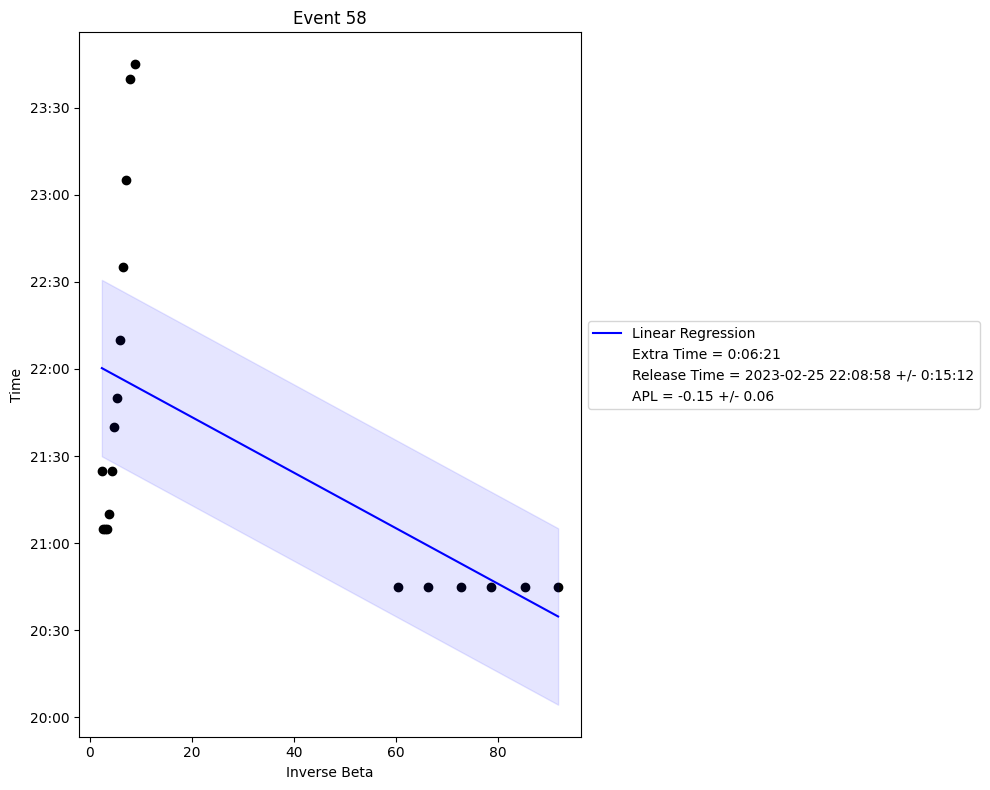

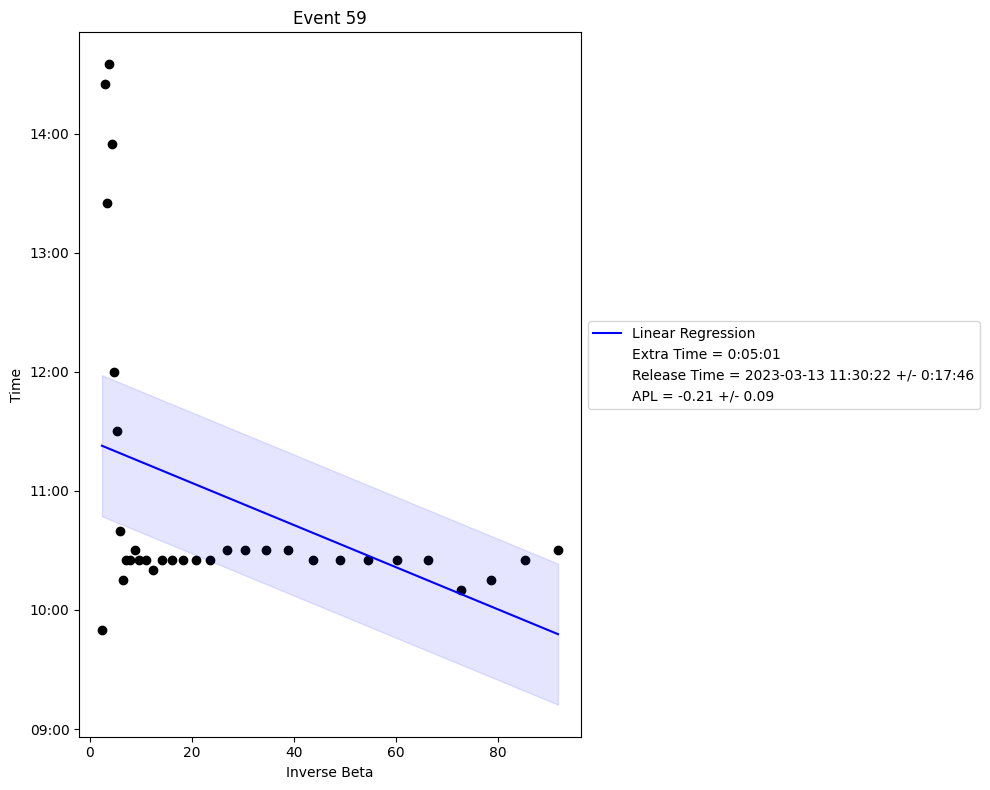

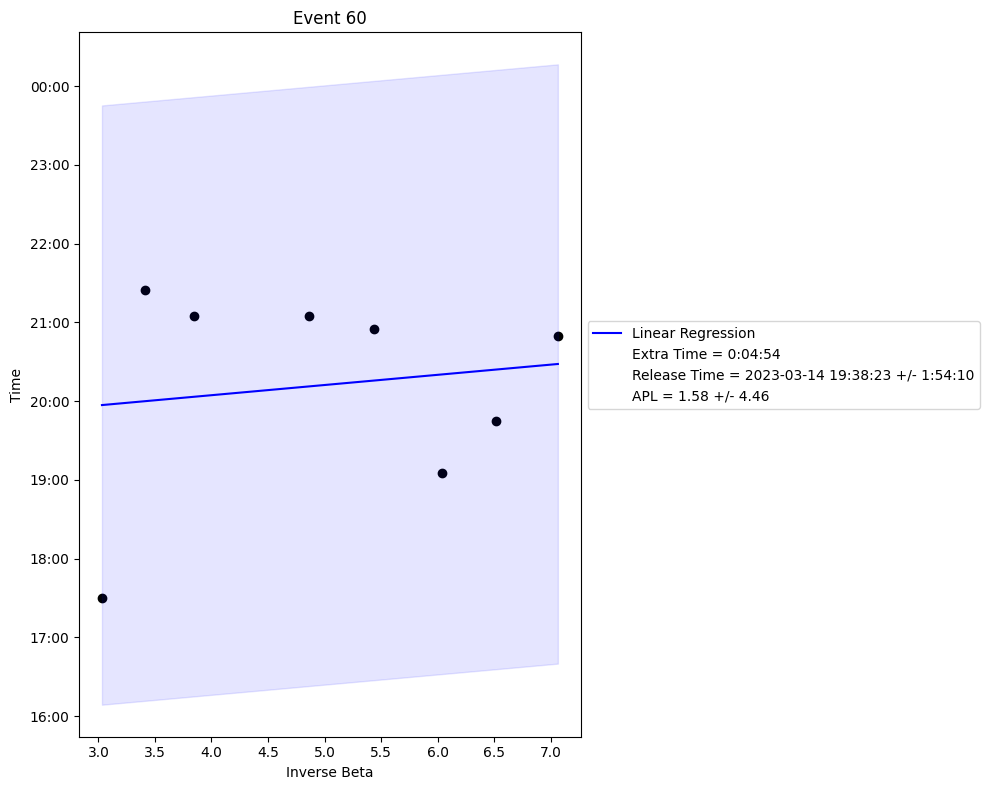

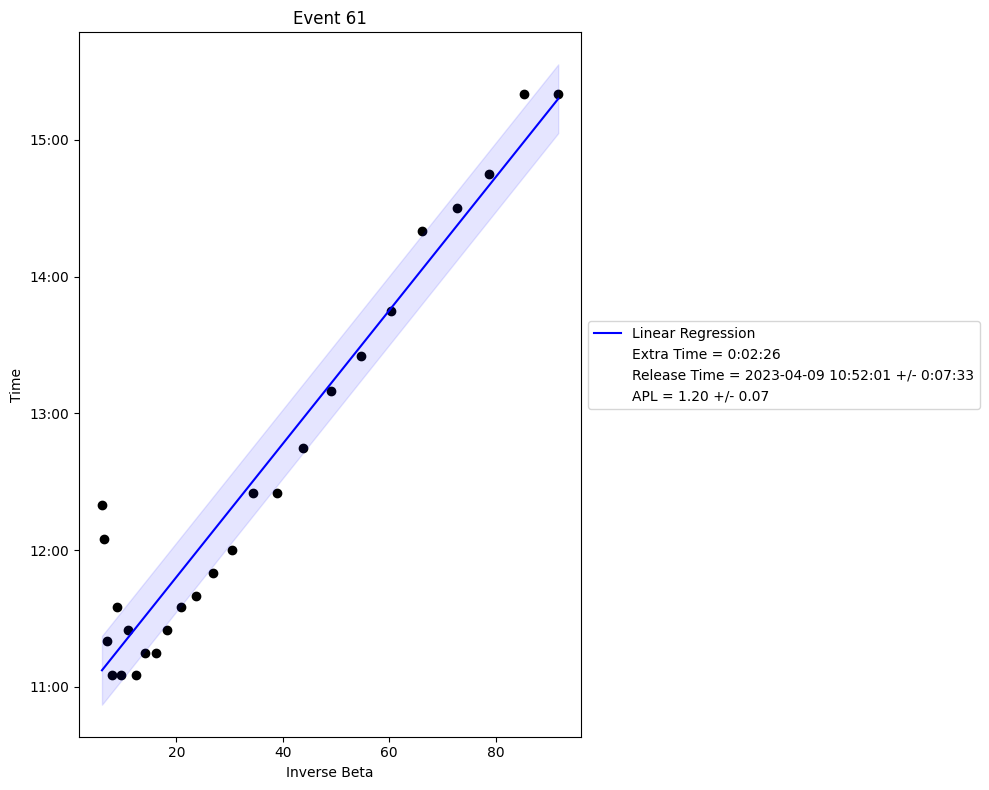

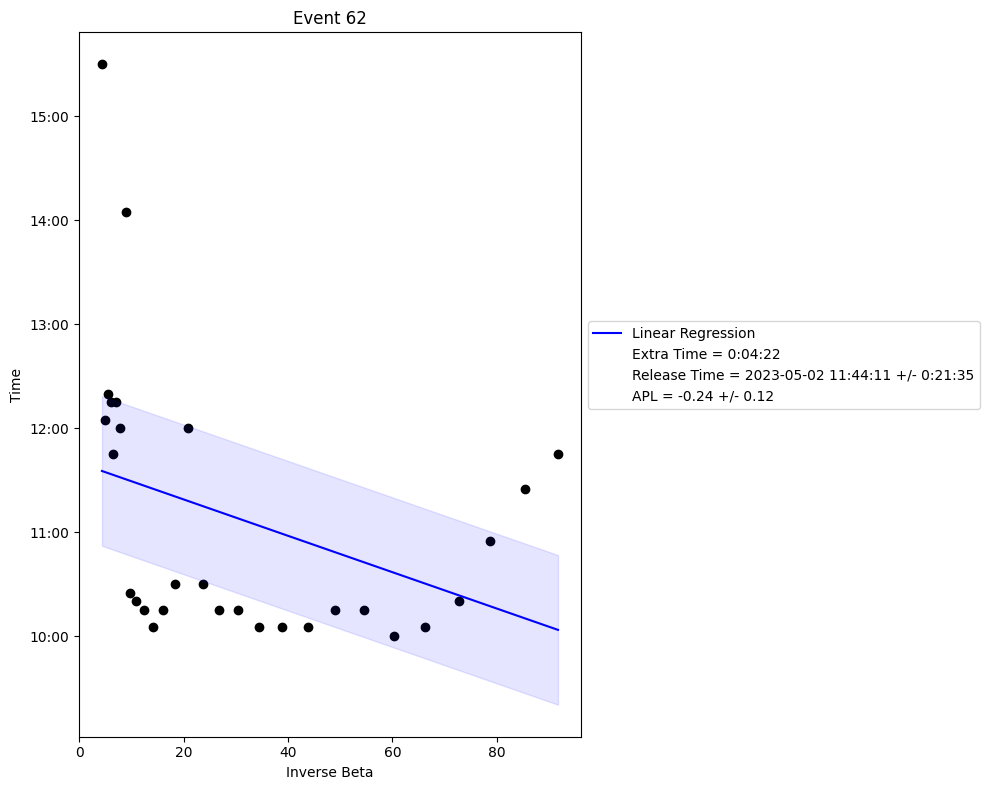

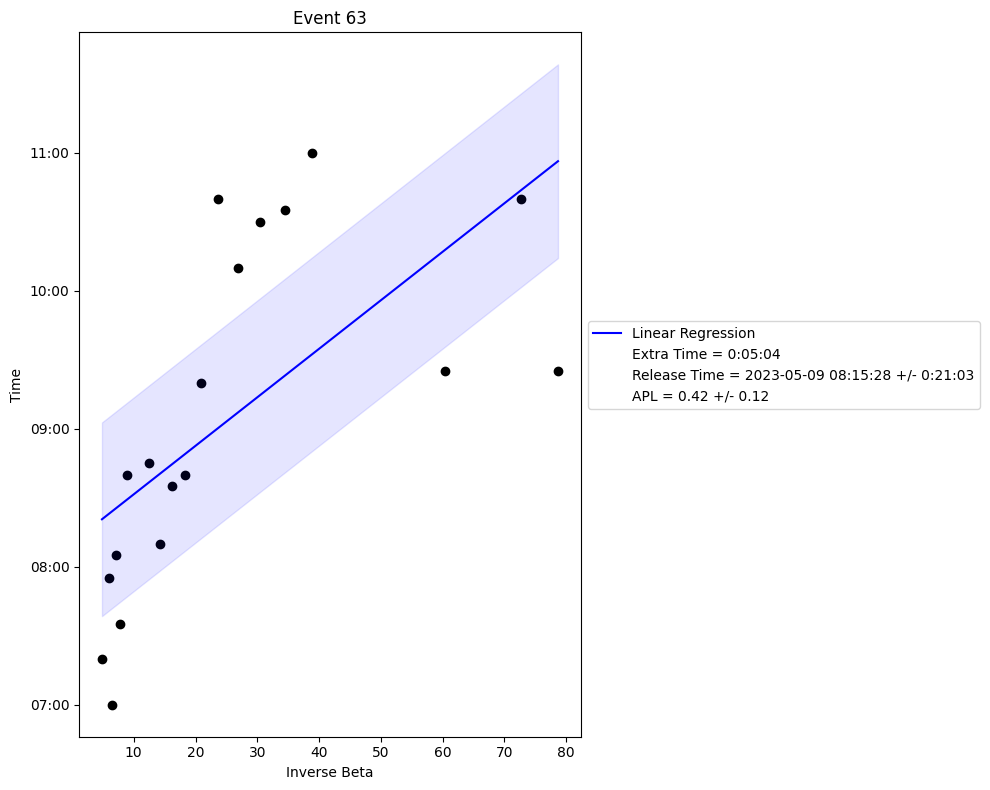

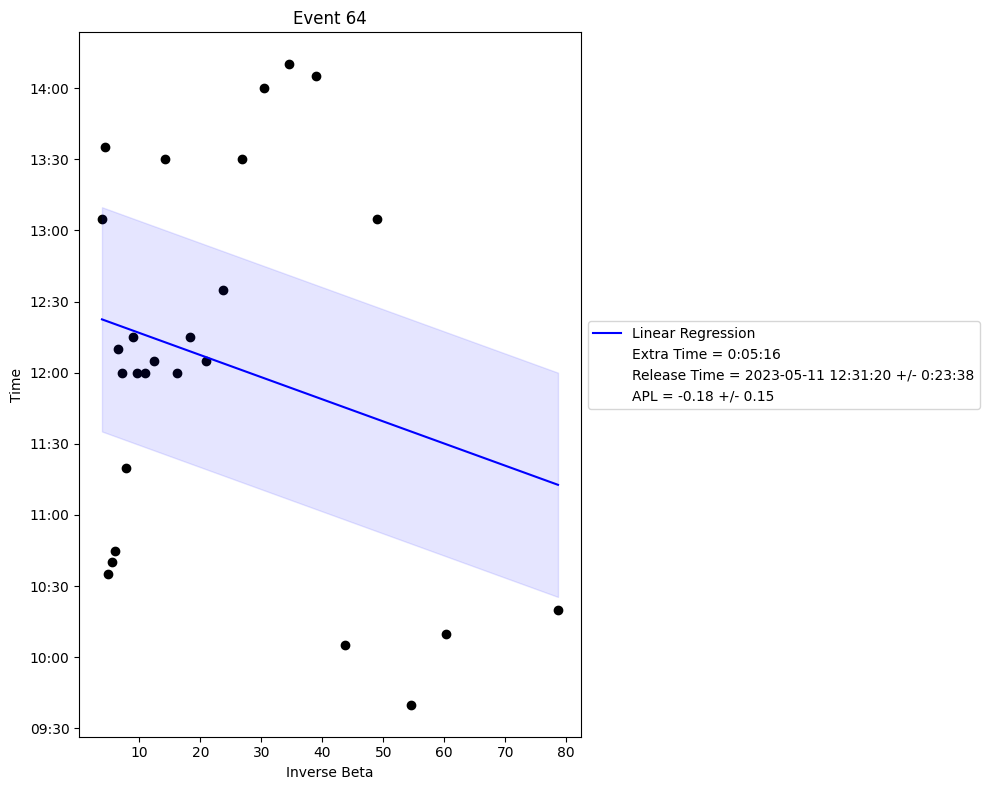

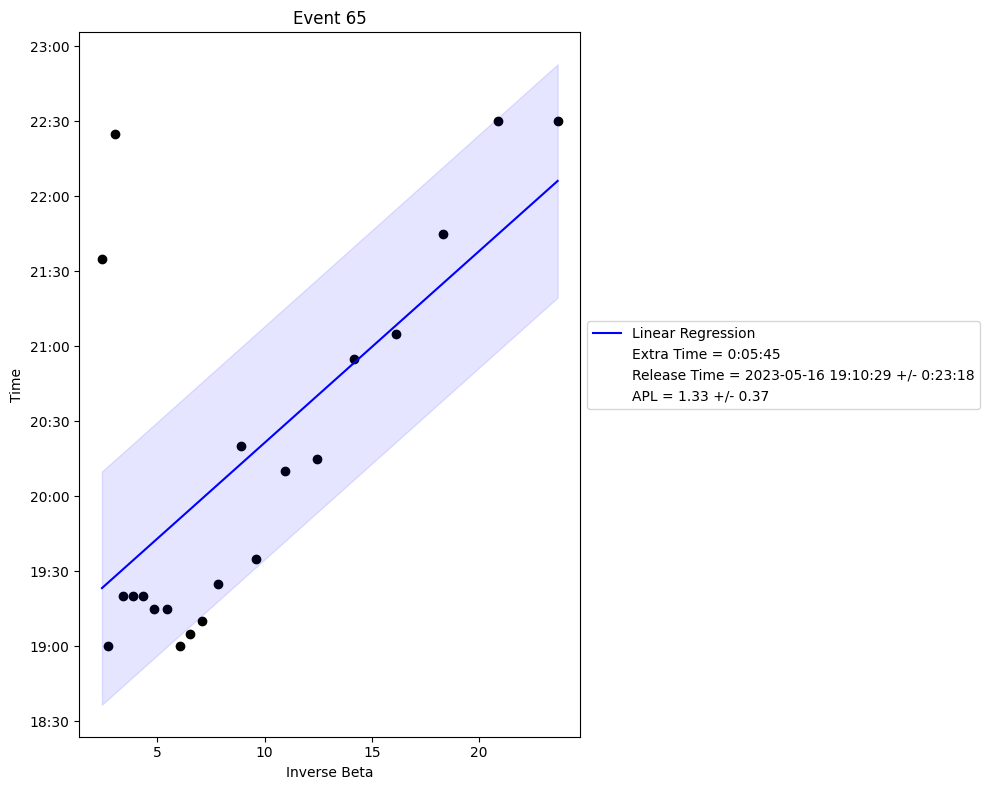

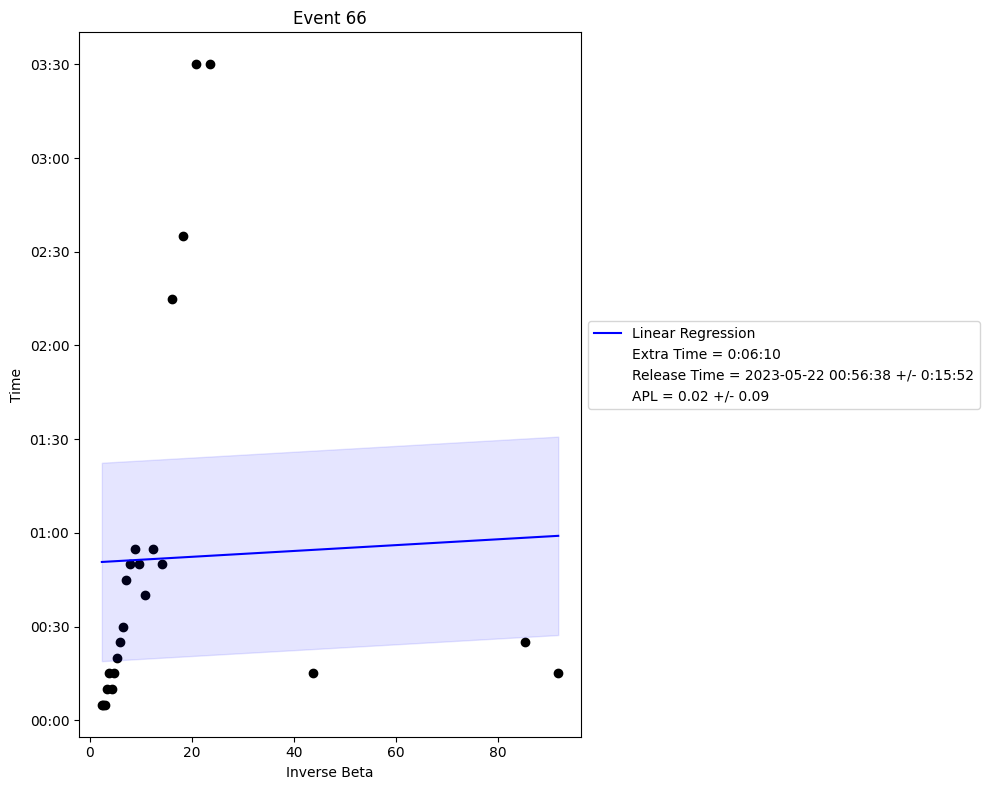

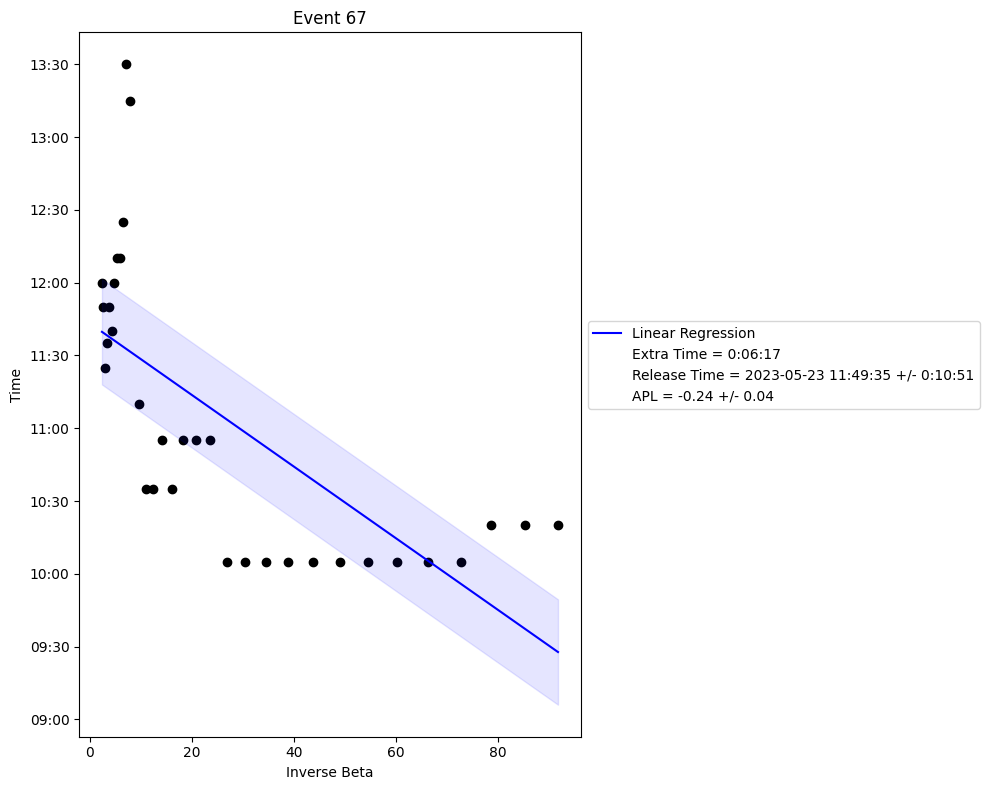

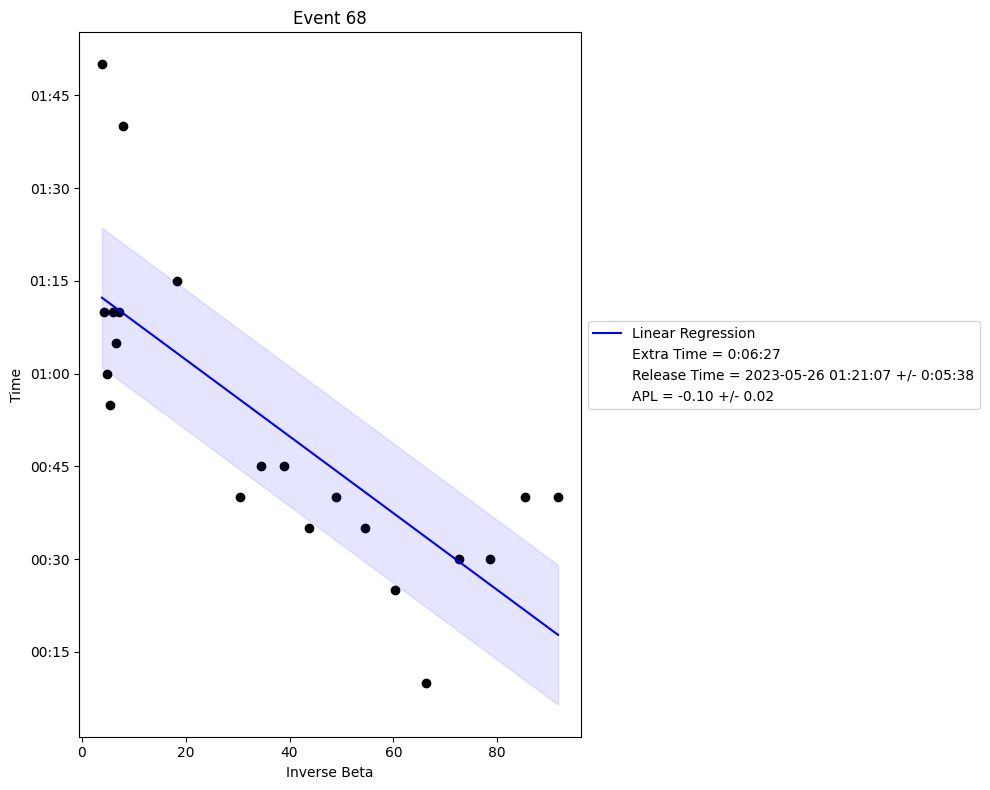

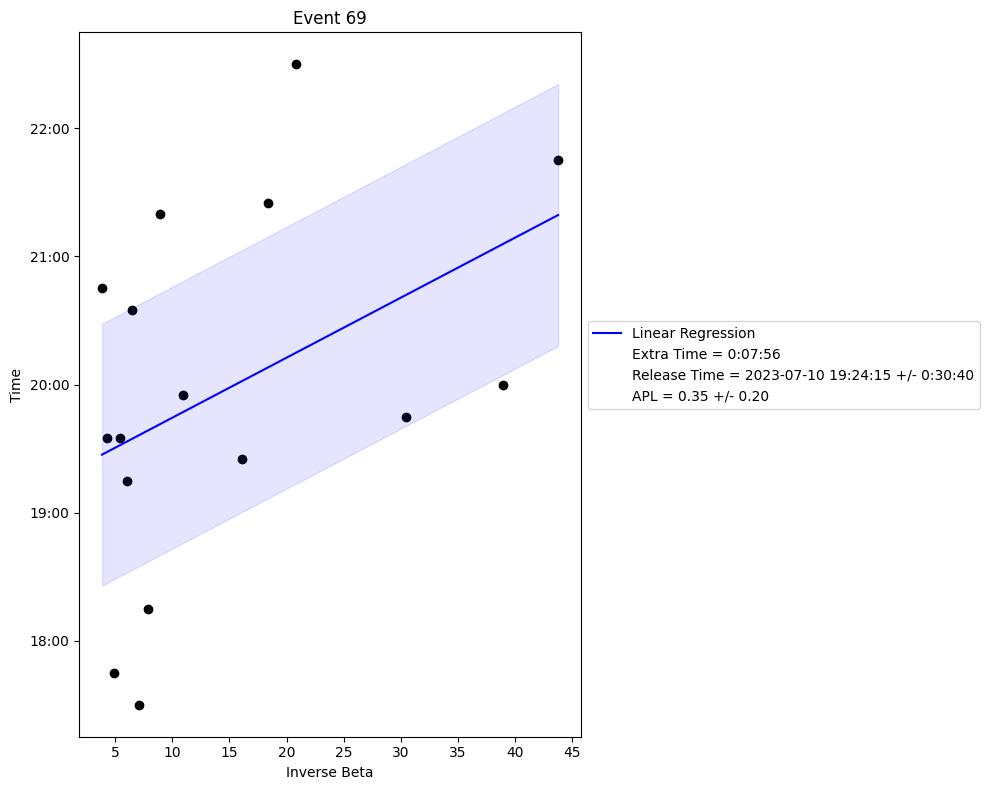

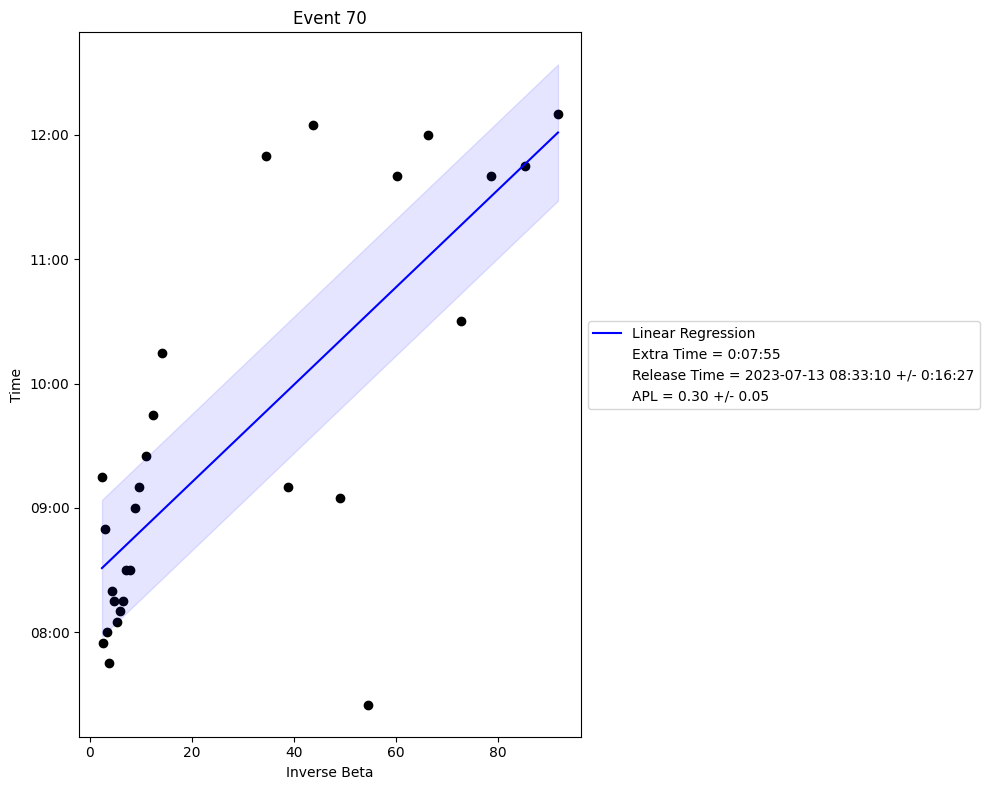

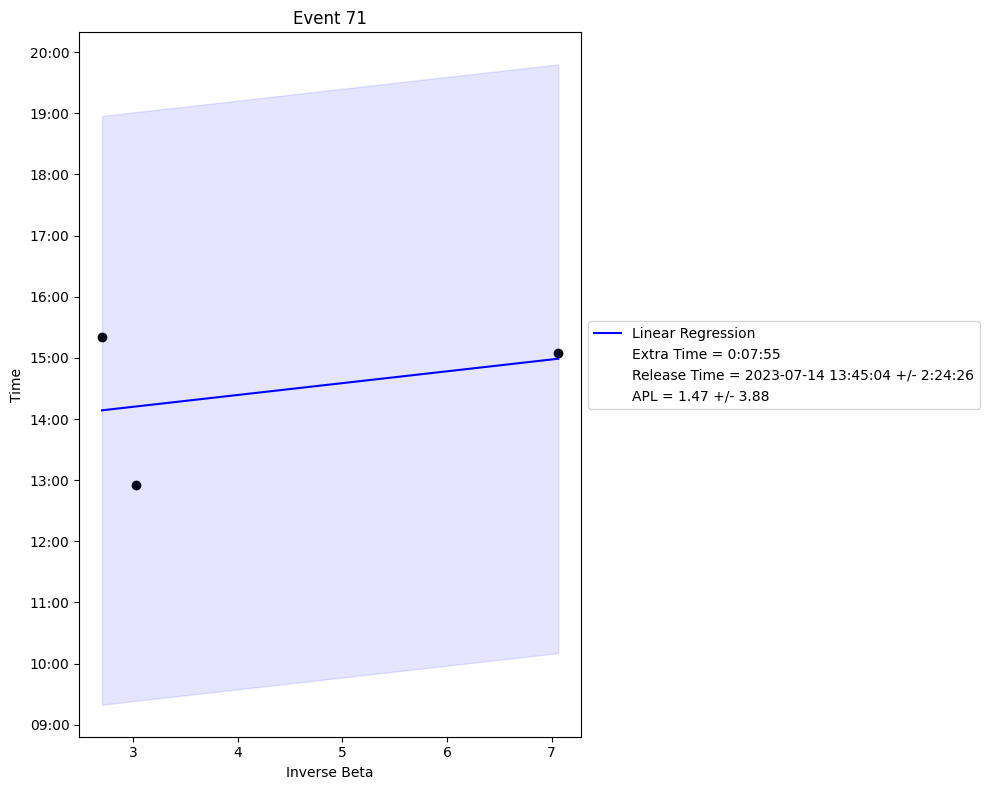

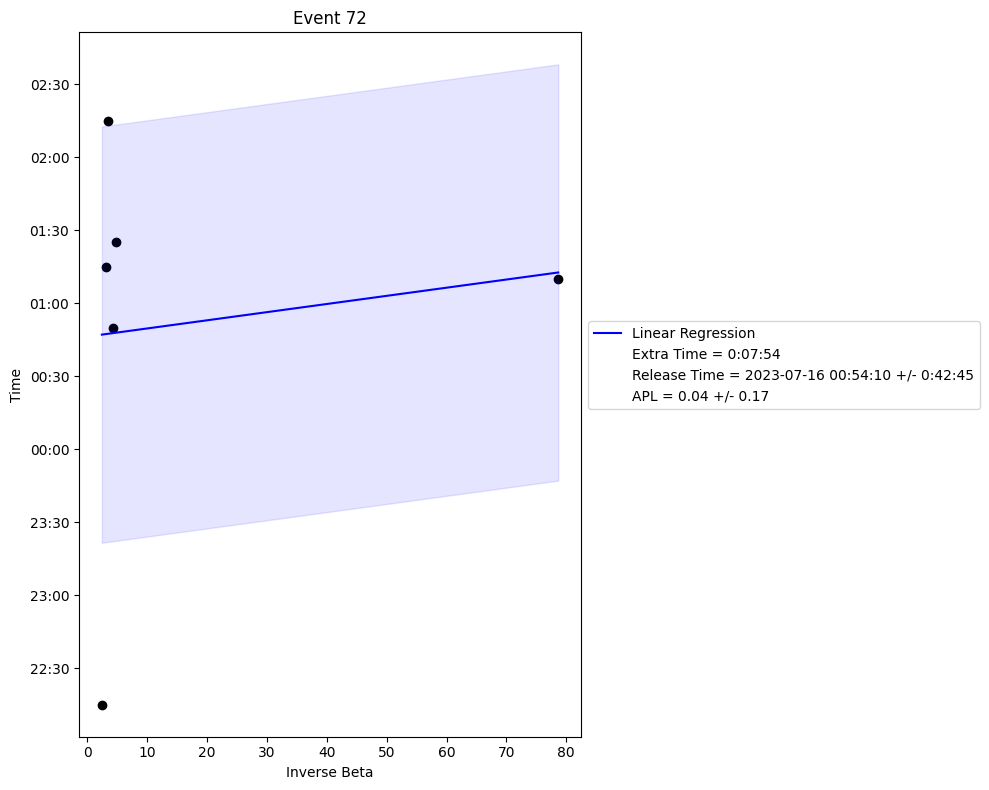

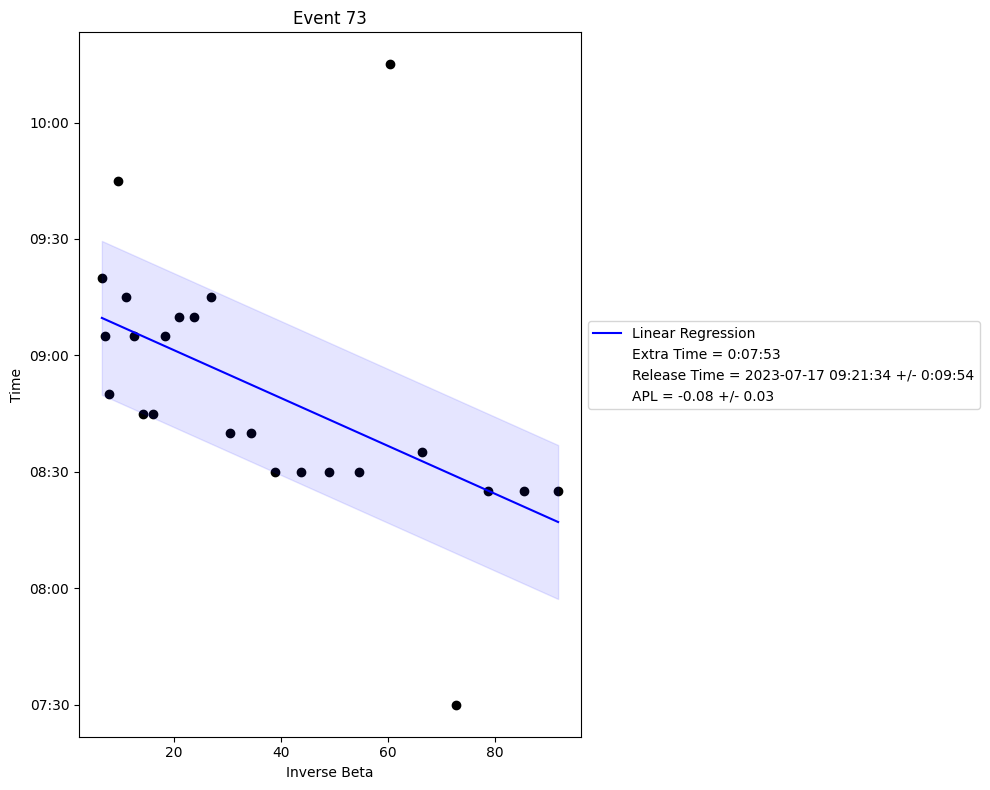

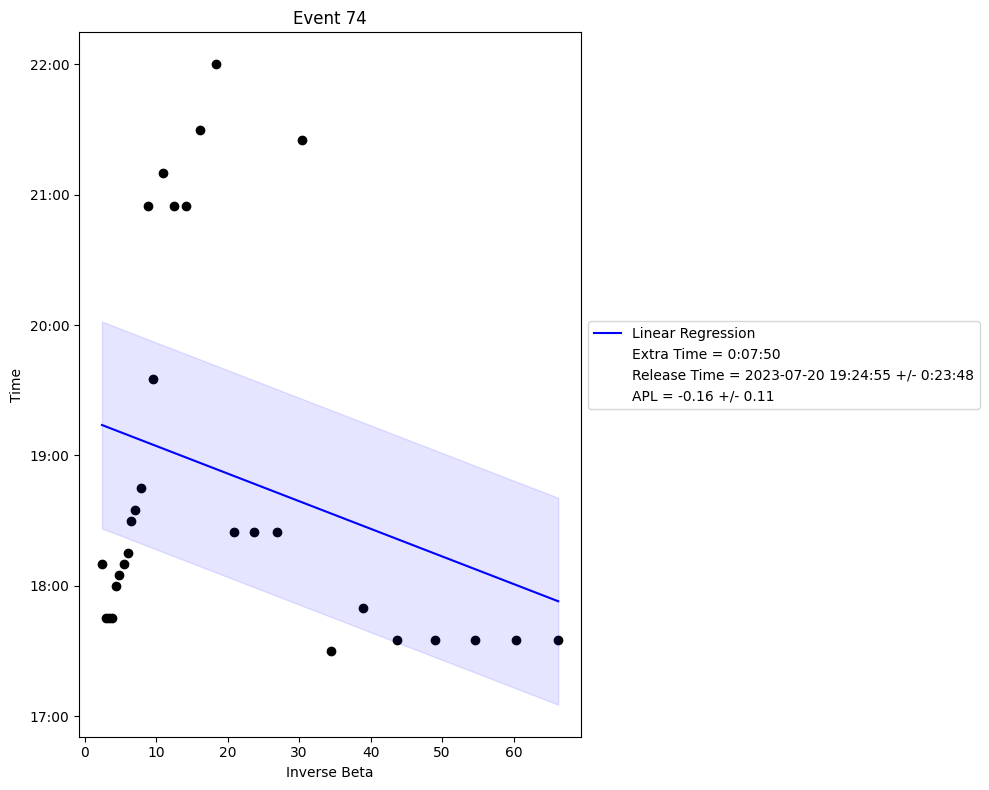

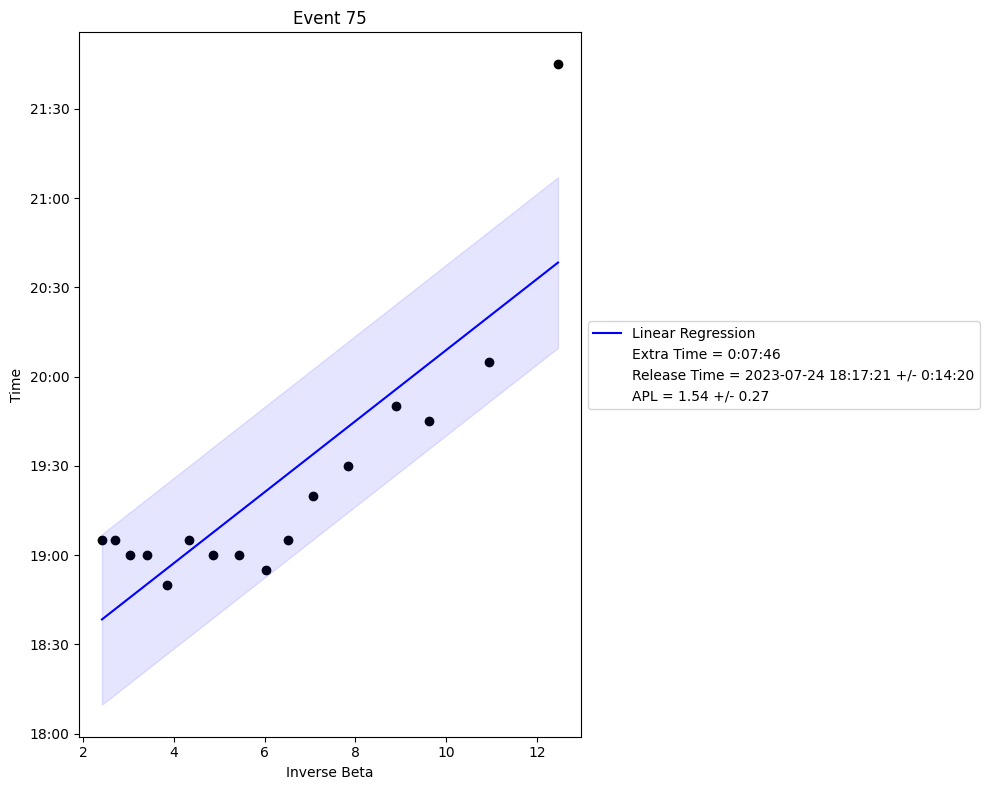

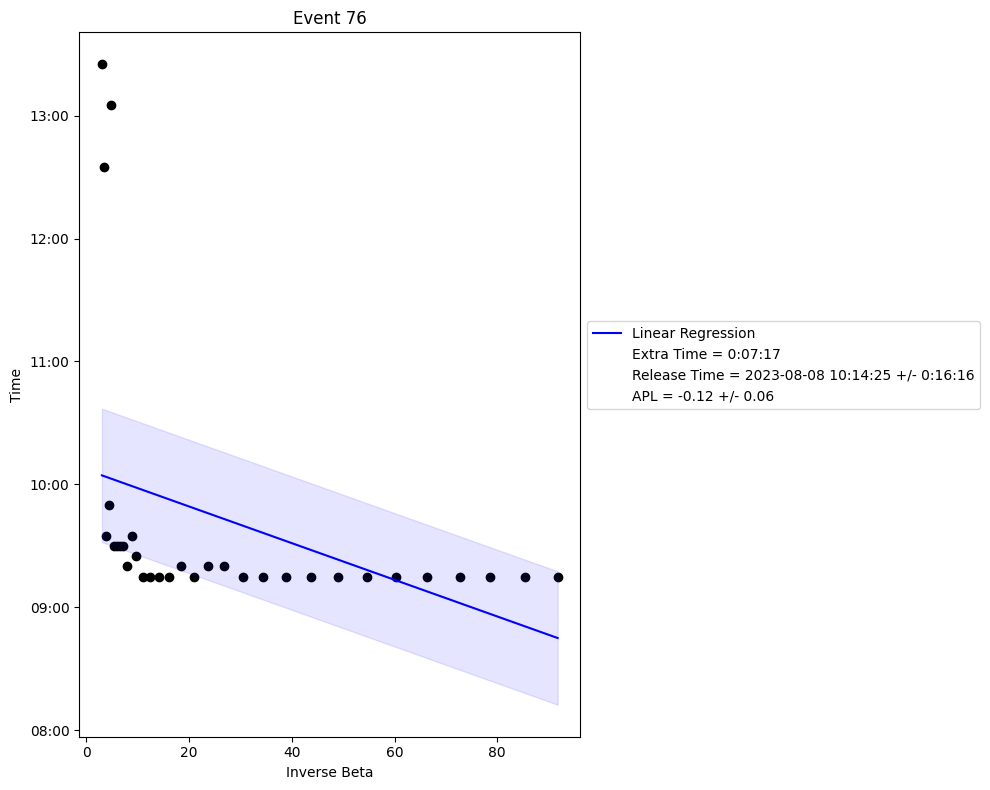

In [31]:
for index_event, df_event in df_options.groupby(level=0):
    vda_points = []
    t_sun_to_observer = astrospice.generate_coords('SOLAR ORBITER', df_times.loc[index_event]["Start Time"]).transform_to(heliocentric).distance.to(u.au)[0].value * AU_TO_M_RATIO / C
    for sensor in [w.description for w in list_wgt_chk_sensors if w.value]:
        try:
            for particle in [w.description for w in list_wgt_chk_particles if w.value]:
                if particle == "protons":
                    particle_prefix = PROTON_COLUMN_PREFIX
                elif particle == "electrons":
                    particle_prefix = ELECTRON_COLUMN_PREFIX
                for channel, df_channel in df_event.loc[index_event, sensor, particle, particle_prefix].groupby(level=0):
                    channel_viewings = list(df_channel.loc[channel].index)
                    if len(channel_viewings) == 1:
                        if chosen_onsets is None or chosen_onsets.loc[index_event, sensor, particle, particle_prefix, channel]["Viewing"] == channel_viewings[0]:
                            # if use every onset or the viewing matches the chosen
                            vda_points.append((df_channels_chars.loc[sensor, particle, channel]["Inverse Beta"], df_channel.loc[channel, channel_viewings[0]]["Onset Time"].to_pydatetime().timestamp()))
                    else:
                        # Multiple viewings available
                        if chosen_onsets is None:
                            # Use every onset (default hierarchy of choice)
                            for viewing in VIEWINGS_HIERARCHY:
                                if viewing in channel_viewings:
                                    vda_points.append((df_channels_chars.loc[sensor, particle, channel]["Inverse Beta"], df_channel.loc[channel, viewing]["Onset Time"].to_pydatetime().timestamp()))
                                    break
                        elif chosen_onsets.loc[index_event, sensor, particle, particle_prefix, channel]["Viewing"] in channel_viewings:
                            # Chosen viewing exists
                            vda_points.append((df_channels_chars.loc[sensor, particle, channel]["Inverse Beta"], df_channel.loc[channel, chosen_onsets.loc[index_event, sensor, particle, particle_prefix, channel]["Viewing"]]["Onset Time"].to_pydatetime().timestamp()))
                        else:
                            # Consider throwing warning (Chosen viewing not available)
                            pass
        except KeyError:
            continue
    
    if len(vda_points) < 2:
        # Not enough points for the linear regression
        # Consider throughing warning
        print(f"Not enough onset points in event {index_event}.")
        continue
    
    vda_points = sorted(vda_points, key=lambda x: x[0])
    inv_betas = np.array([p[0] for p in vda_points])
    timestamps = np.array([p[1] for p in vda_points])

    try:
        p, V = np.polyfit(inv_betas, timestamps, 1, cov=True)
        a = p[0]
        b = p[1]
        a_error = np.sqrt(V[0][0])
        b_error = np.sqrt(V[1][1])
    except ValueError:
        # not enough points for cov matrix
        print(f"Not enough points for covariance matrix generation in event {index_event}")
        a, b = np.polyfit(inv_betas, timestamps, 1)
        a_error = 0
        b_error = 0

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(inv_betas,
               [datetime.fromtimestamp(t) for t in timestamps],
               color="black")
    ax.plot(inv_betas,
            [datetime.fromtimestamp(a*x+b) for x in inv_betas],
            label="Linear Regression",
            color="blue")
    ax.fill_between(inv_betas,
                    [datetime.fromtimestamp(a*x+b-2*b_error) for x in inv_betas],
                    [datetime.fromtimestamp(a*x+b+2*b_error) for x in inv_betas],
                    color="blue",
                    alpha=0.1)
    plt.title(f"Event {index_event}")
    plt.xlabel("Inverse Beta")
    plt.ylabel("Time")
    time_formatter = mdates.DateFormatter("%H:%M")
    ax.yaxis.set_major_formatter(time_formatter)
    plt.plot([], [], alpha=0, label=f"Extra Time = {str(timedelta(seconds=t_sun_to_observer)).split('.')[0]}")
    plt.plot([], [], alpha=0, label=f"Release Time = {datetime.fromtimestamp(b + t_sun_to_observer).strftime('%Y-%m-%d %H:%M:%S')} +/- {str(timedelta(seconds=b_error)).split('.')[0]}")
    plt.plot([], [], alpha=0, label=f"APL = {a / t_sun_to_observer:.2f} +/- {a_error / t_sun_to_observer:.2f}")
    plt.legend(bbox_to_anchor=(1, 0.6), loc="upper left")
    plt.tight_layout()
    plt.show()